# RSJ model: CPR of $I(\phi)=[\sin(\phi)+\eta\sin(2\phi)]+A(\sin(\phi+C)+\eta\sin[2(\phi+C)])$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import rc
rc('text', usetex=True)
from scipy.integrate import odeint
from scipy.optimize import fmin
from scipy.io import savemat

In [2]:
%matplotlib inline

In [3]:
%load_ext Cython

In [4]:
h=6.626e-34
hbar=h/2/np.pi
Qe=1.608e-19

In [5]:
%%cython
cimport numpy as np
from libc.math cimport sin, cos, atanh,pi
import numpy as np

h=6.626e-34
hbar=h/2/pi
Qe=1.608e-19
Ic=2e-6
Rn=13
cpdef double CPR(double G, double A, double eta, double C):
    '''
        Current-phase relationship for the junction
    '''
    return sin(G)+eta*sin(2*G)+A*sin(G+C)+A*eta*sin(2*G+2*C)
    
cpdef double dGdt(G,double t,double I,double A, double eta,double C):
    '''
        Define y = [gamma]
        dy_dt =  - f(gamma) + i(t)) 
    '''
    der = 2*Qe*Rn*(I-Ic*CPR(G,A,eta,C))/hbar
    return der 


### Plot CPR

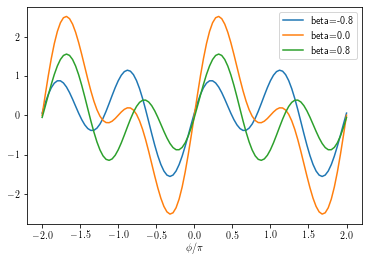

In [11]:
eta=0.7
A=0.7
def CPR2(G, A, eta, C):
    return np.sin(G)+eta*np.sin(2*G)+A*np.sin(G+C)+A*eta*np.sin(2*G+2*C)
phi=np.linspace(-2,2,101)*np.pi

beta=np.pi*np.linspace(-0.8,0.8,3)

Is=np.empty([len(phi),len(beta)])
plt.figure()
for j in range(0,len(beta)):
    for i in range(0,len(phi)):
        Is[i,j]=CPR2(phi[i],A,eta,beta[j])
    plt.plot(phi/np.pi,Is[:,j],label="beta="+str(np.round(beta[j]/np.pi,3)))
plt.xlabel('$\phi/\pi$')
plt.legend(loc=1)


In [7]:
from IPython import display

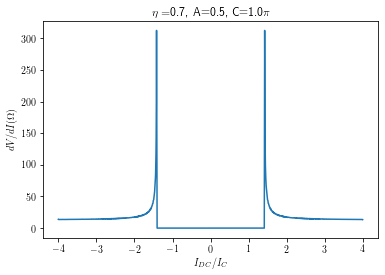

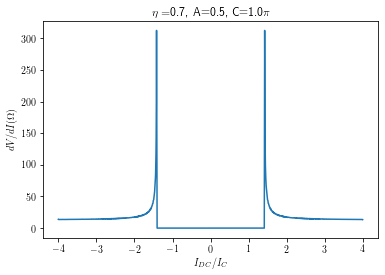

In [69]:
#f0=2*Qe*Ic*Rn/h

#C=np.pi*np.arange(-1,1.05,0.05)
#eta=0.7
#A=0.5
#IDC_step=0.005
#IDC_Sweep=np.array([-4,4,IDC_step])*Ic
#IDC_array=np.arange(IDC_Sweep[0],IDC_Sweep[1],IDC_Sweep[2])
#V=np.empty([len(C),len(IDC_array)])
#DVDI=np.empty([len(C),len(IDC_array)])

#print(IDC_array.shape)
#print(C.shape)
#plt.ion()
#fig=plt.figure()
#ax=fig.add_subplot(1,1,1)

for x in range(0,len(C)):
    display.clear_output(wait=True)

    for j in range(0,len(IDC_array)):
        t=np.arange(0,500.01,0.01)/f0
        G_array= odeint(dGdt,0,t,args=(IDC_array[j],A,eta,C[x]))
        #V[x,j]=np.squeeze(G_array[-1]-G_array[-1501])*f0*(hbar/2/Qe)/15 # Doesn't work for some cases.
        V[x,j]=np.mean(np.gradient(G_array[:-3001,0]))/(0.01/f0)*(hbar/2/Qe)
    DVDI[x,:]=np.gradient(V[x,:],IDC_step*Ic)
    #print("C="+str(C[x]/np.pi)+"$\pi$",end="\r")
    ax.clear()
    ax.plot(IDC_array/Ic,DVDI[x,:])
    plt.title("$\eta=$"+str(eta)+", A="+str(A)+", C="+str(np.round(C[x]/np.pi,3))+"$\pi$")
    plt.xlabel("$I_{DC}/I_C$")
    plt.ylabel("$dV/dI(\Omega)$")
    display.display(plt.gcf())

### Plot map and save data

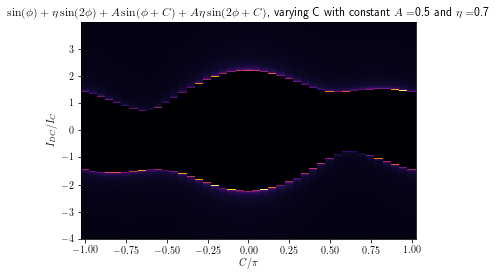

In [70]:
#plt.figure()
#plt.pcolor(C/np.pi,IDC_array/Ic,np.transpose(DVDI),cmap='inferno',shading='auto')
#plt.xlabel("$C/\pi$")
#plt.ylabel("$I_{DC}/I_C$")
#plt.title("$\sin(\phi)+\eta\sin(2\phi)+A\sin(\phi+C)+A\eta\sin(2\phi+C)$, varying C with constant $A=$"+str(A)+" and $\eta=$"+str(eta))
#plt.savefig("./eta0p7_A0p5/two_channels_A0p5_eta_0p7_step_0p005_41ptC.pdf")

#savemat("./eta0p7_A0p5/simulation_dVdI_vs_C_constant_A_0p5_eta_0p7_two_channels_step_0p005.mat",mdict={'IDC':IDC_array,'C':C,'V':V,'DVDI':DVDI})


## Load Data and Plot

### Convert mat to hdf5

In [6]:
from scipy.io import loadmat, savemat
import h5py
import os

### Merge the mat file into a single mat file

In [7]:
dataDir = "./several_eta_A/"
merged_data={}

sorted_file_list=sorted(os.listdir(dataDir)) # sort the file list first by name
#print(sorted_file_list)
for file in sorted_file_list:
    d=loadmat(dataDir+file)
    if merged_data=={}:
        merged_data=d.copy()
        merged_data.pop('__globals__')
        merged_data.pop('__header__')
        merged_data.pop('__version__')
        for i in merged_data.keys():
            merged_data[i]=np.squeeze(merged_data[i])
            if i in ['A','eta']:
                merged_data[i]=np.round(merged_data[i],3)
    else:
        for i in d.keys():
            if i not in ['__globals__',  '__header__', '__version__','IDC','C']:
                if i in ['A','eta']:
                    merged_data[i]=np.dstack((merged_data[i],np.squeeze(np.round(d[i],3))))                
                else:
                    merged_data[i]=np.dstack((merged_data[i],np.squeeze(d[i])))                

for i in merged_data.keys():
    merged_data[i]=np.squeeze(merged_data[i])
    print(str(i)+"_"+str(merged_data[i].shape))
savemat('merged.mat',merged_data)

IDC_(1600,)
C_(41,)
V_(41, 1600, 121)
DVDI_(41, 1600, 121)
eta_(121,)
A_(121,)


### Convert the merged mat to the h5 format

In [8]:
file="merged.mat"
with h5py.File(file[:-4] + '.h5', 'w') as fd:
    for i in merged_data.keys():
        fd[i] = merged_data[i]
    fd.close()

### Convert all the mat files to the hdf5 format

In [278]:
dataDir = "./several_eta_A/"

h5Dir="./several_eta_A_h5/"
for file in os.listdir( dataDir ):
    d=loadmat(dataDir+file)
    with h5py.File(h5Dir+file[:-4] + '.h5', 'w') as fd:
        for i in d.keys():
            if i not in ['__globals__',  '__header__', '__version__']:
                fd[i] = np.squeeze(d[i])
    fd.close()

### Load hdf5

In [9]:
#for file in os.listdir( h5Dir ):
fd= h5py.File('merged.h5','r')

In [10]:
list(fd.keys())

['A', 'C', 'DVDI', 'IDC', 'V', 'eta']

In [11]:
A=fd['A'][...]
print(A.shape)
C=fd['C'][...]
print(C.shape)
DVDI=fd['DVDI'][...]
print(DVDI.shape)
IDC=fd['IDC'][...]
print(IDC.shape)
V=fd['V'][...]
print(V.shape)
eta=fd['eta'][...]
print(eta.shape)

(121,)
(41,)
(41, 1600, 121)
(1600,)
(41, 1600, 121)
(121,)


### Plot all the $R(I_{DC}, C)$ maps

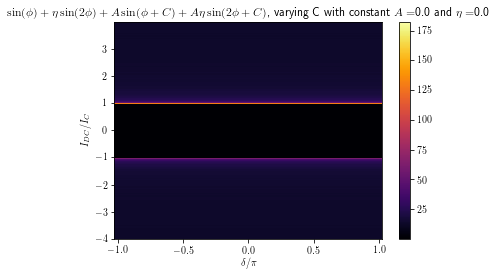

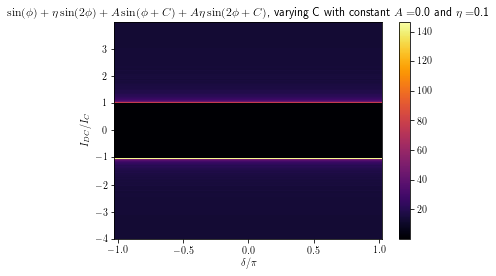

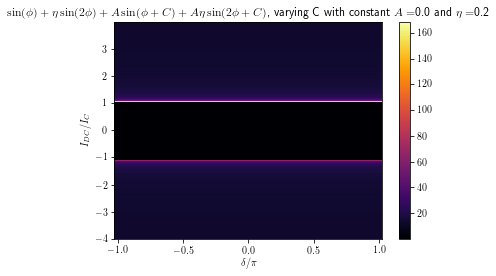

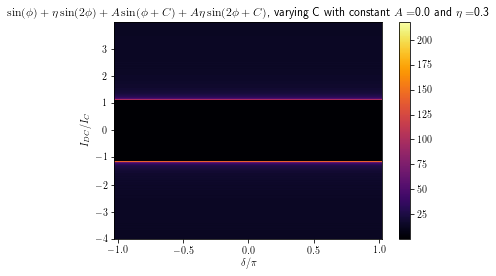

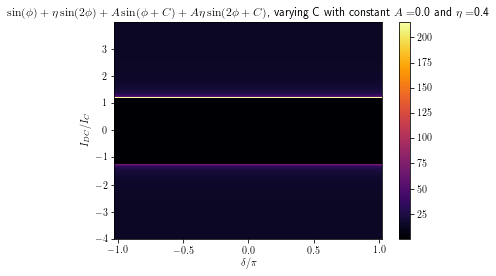

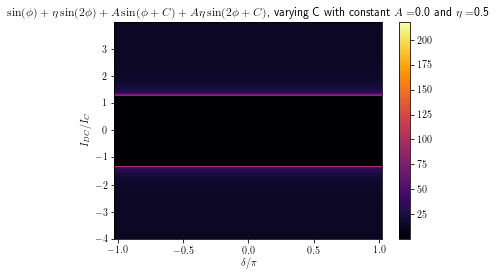

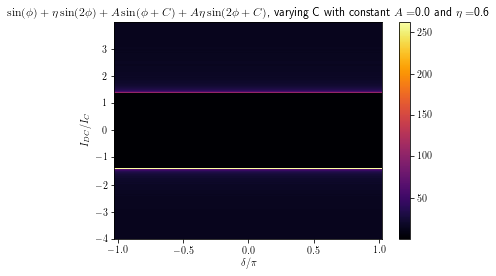

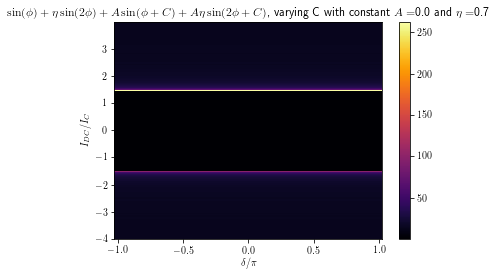

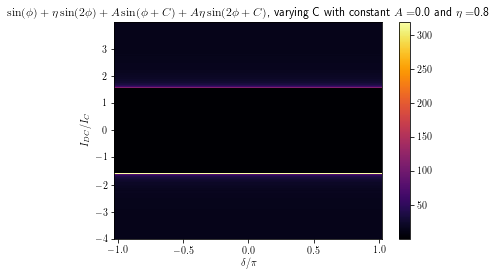

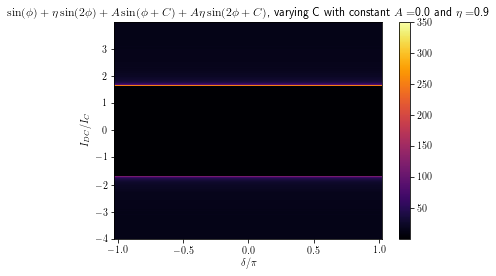

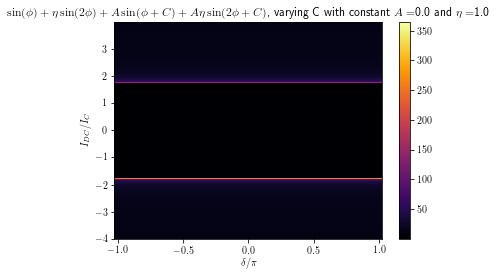

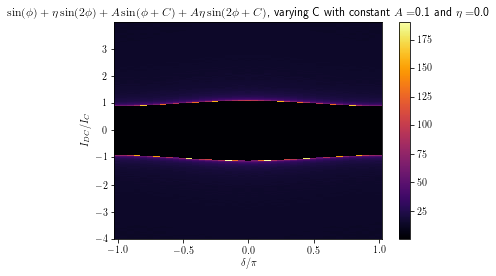

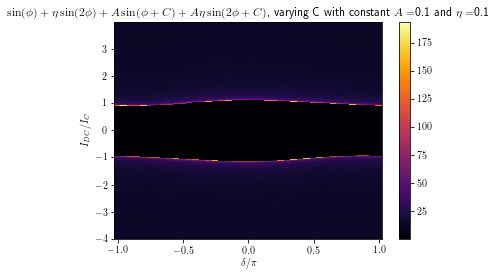

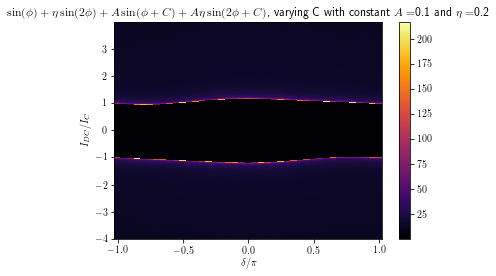

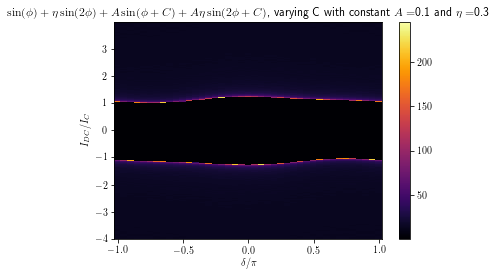

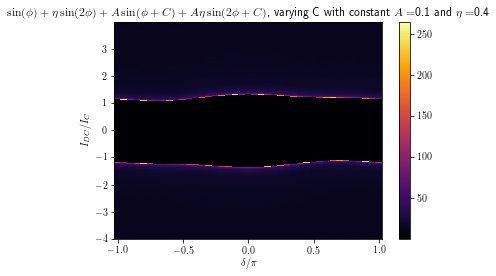

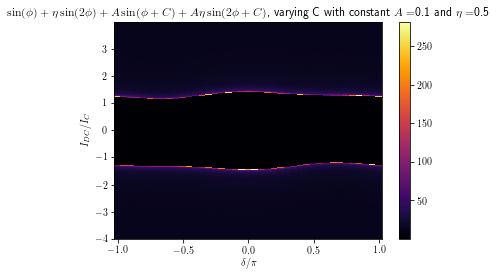

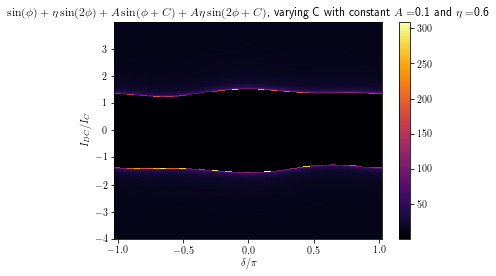

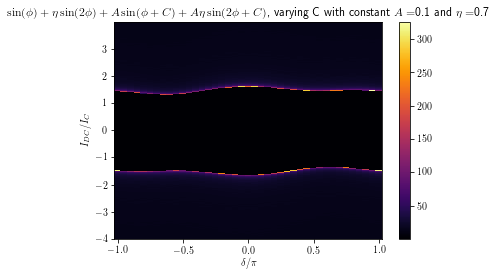

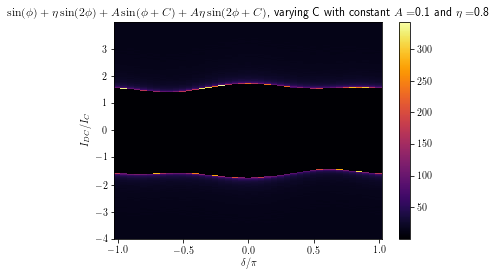

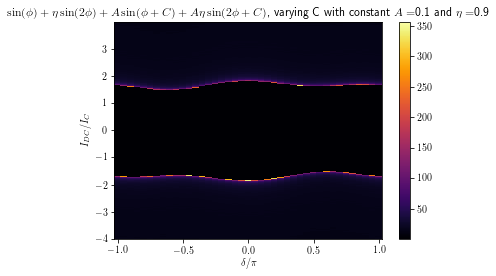

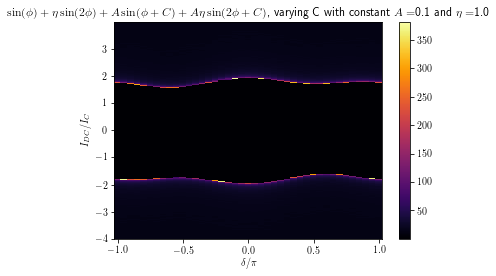

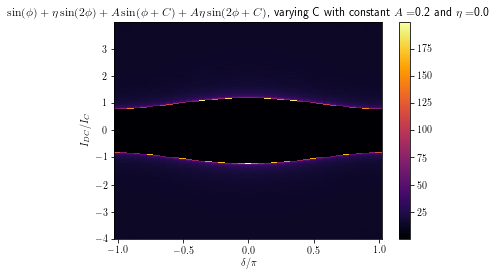

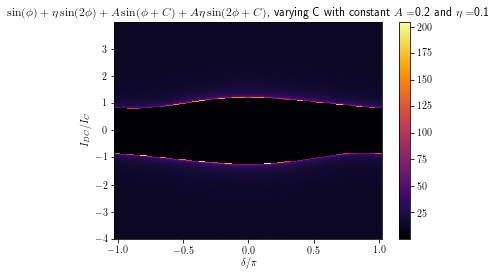

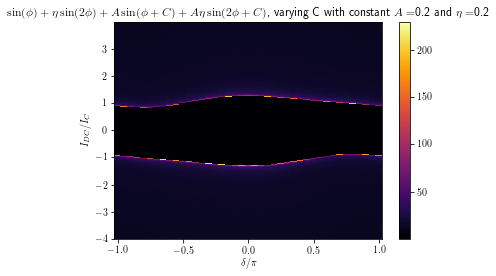

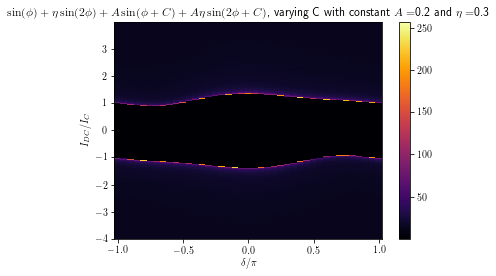

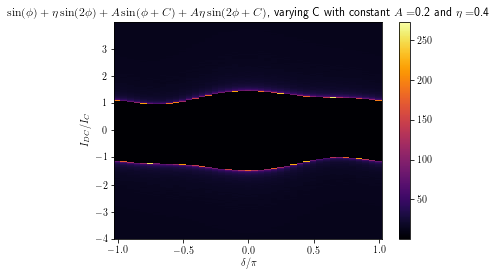

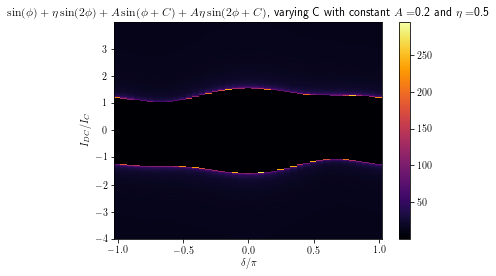

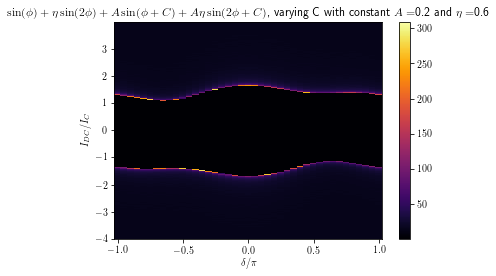

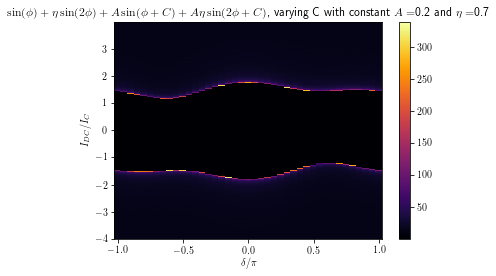

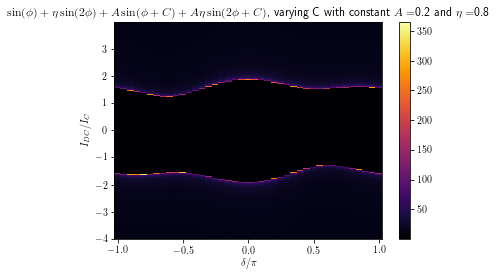

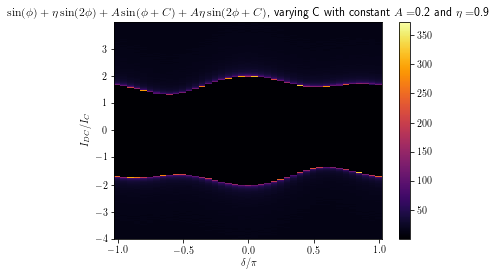

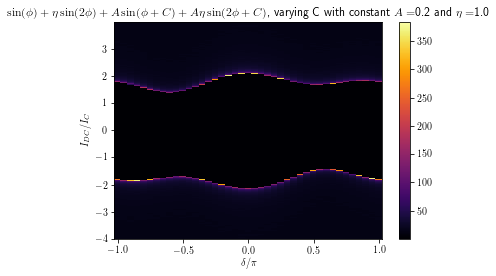

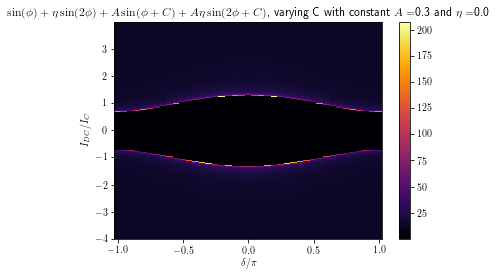

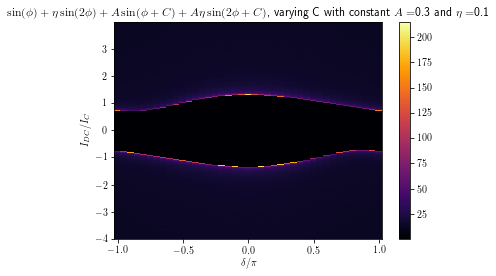

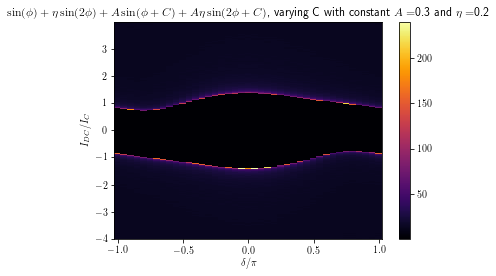

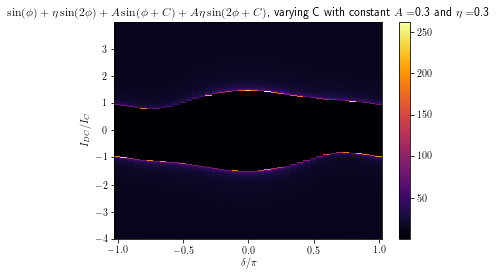

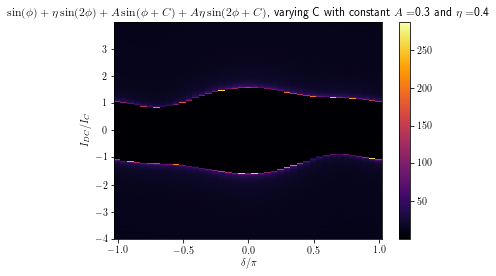

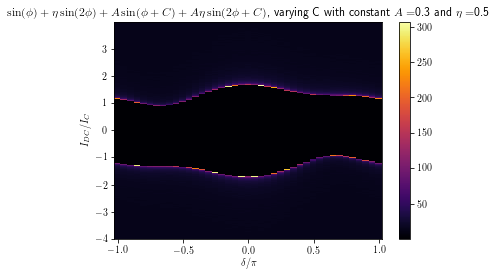

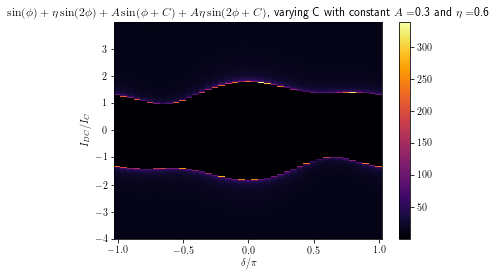

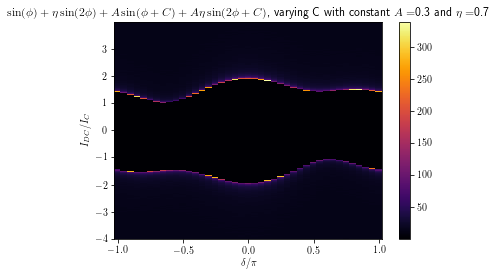

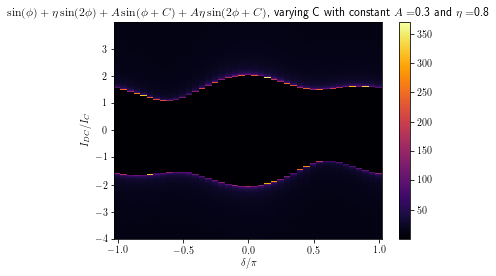

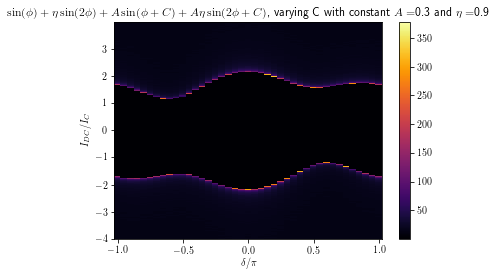

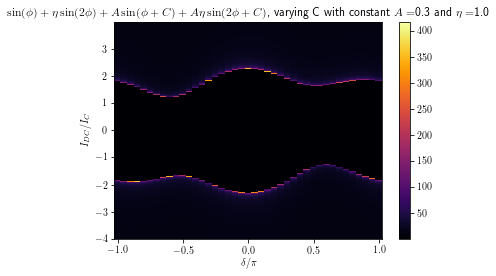

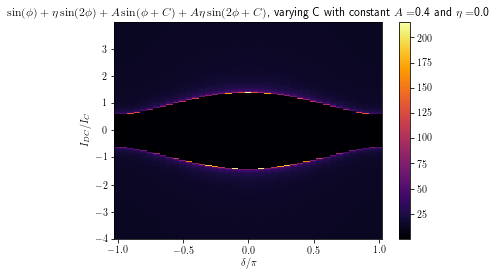

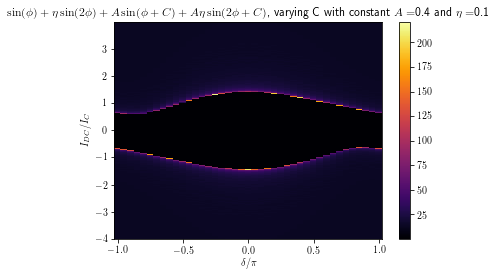

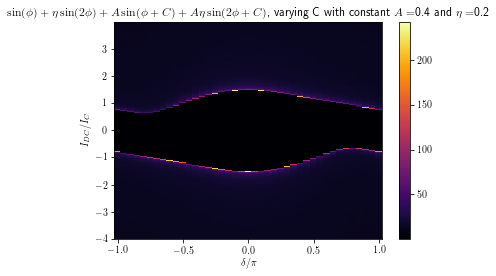

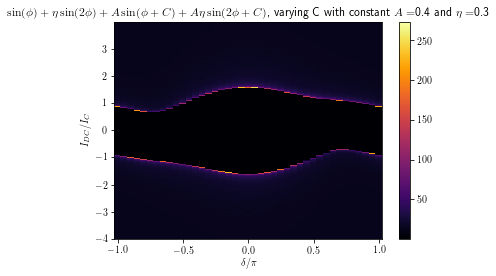

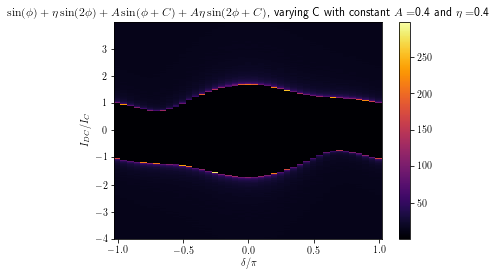

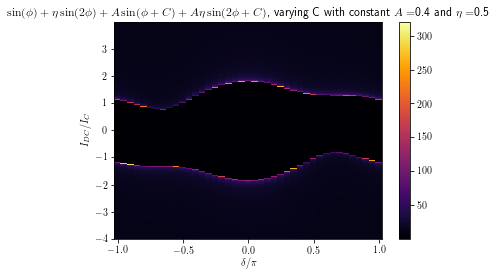

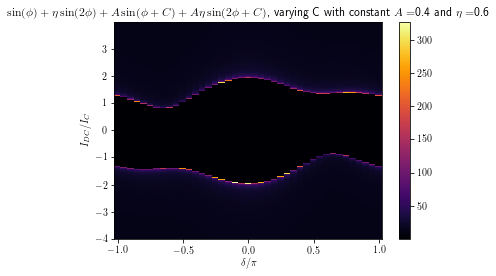

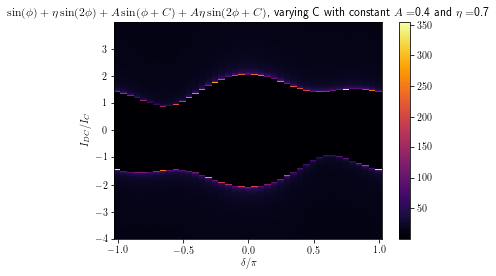

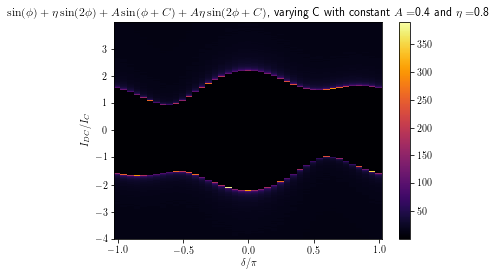

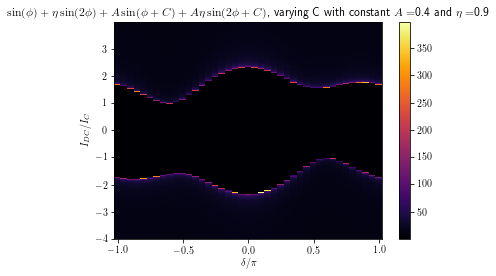

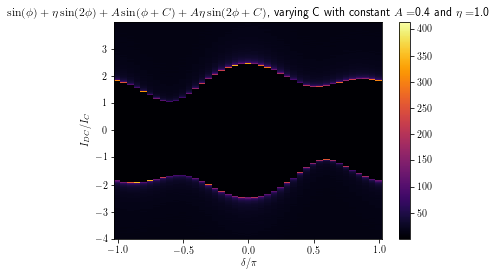

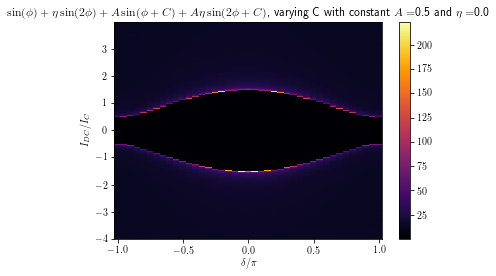

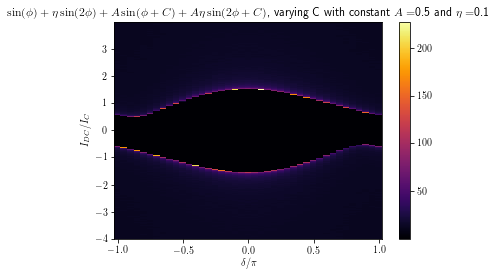

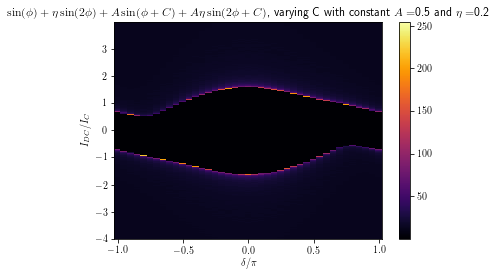

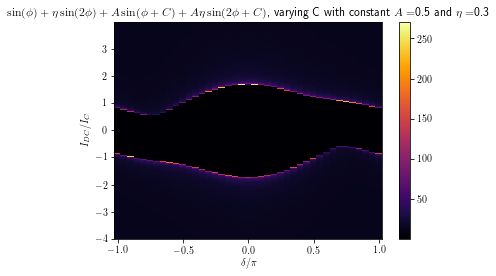

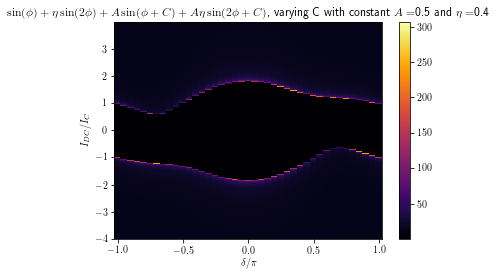

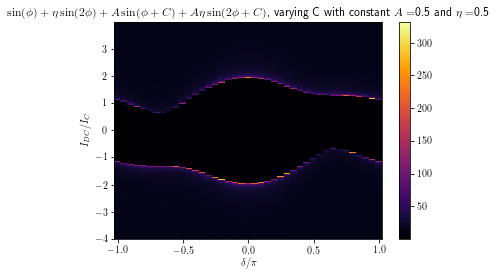

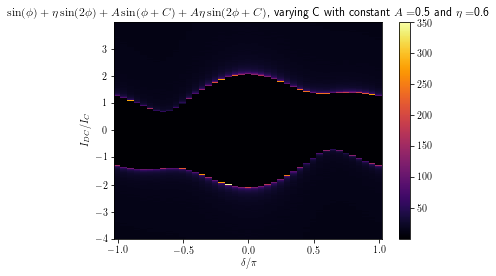

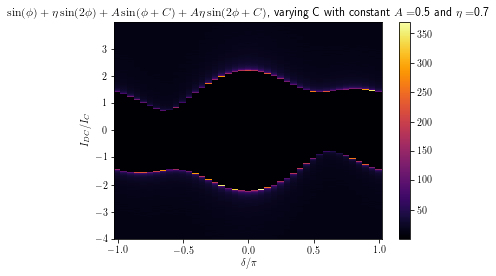

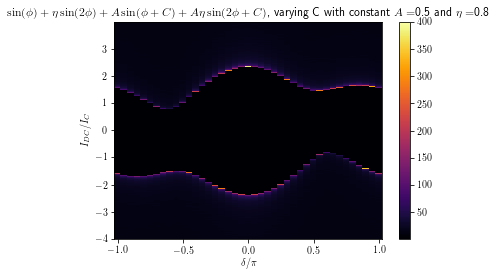

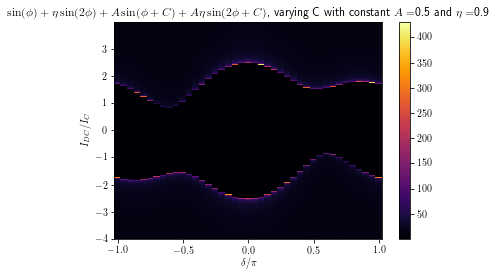

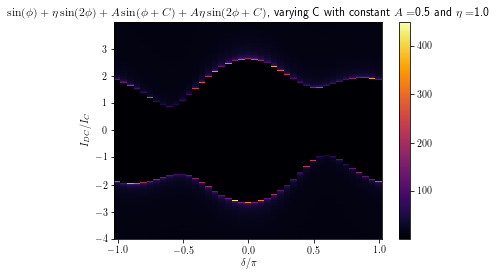

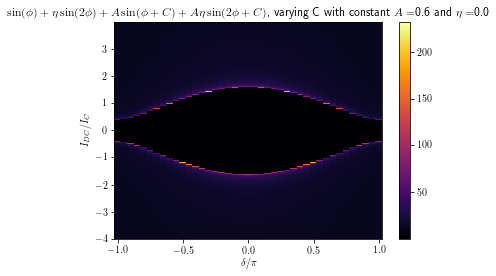

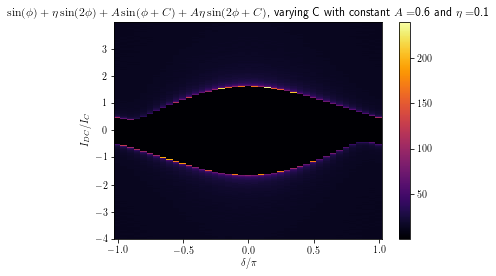

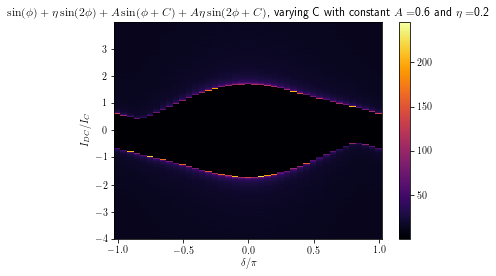

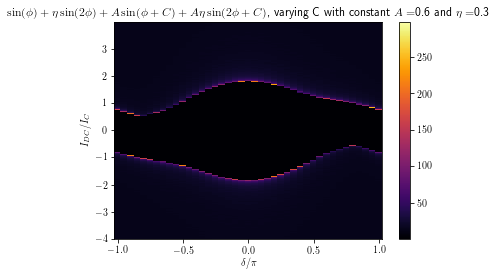

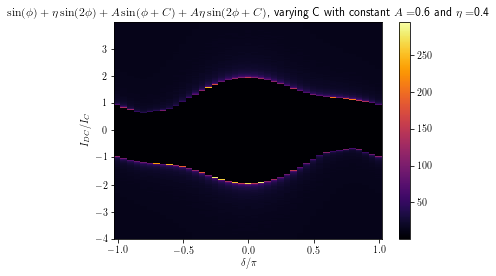

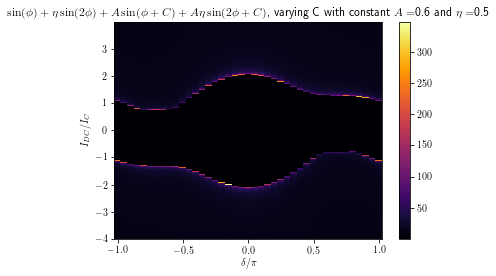

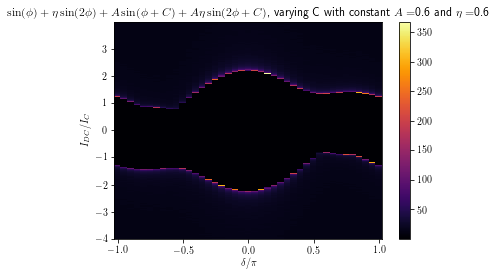

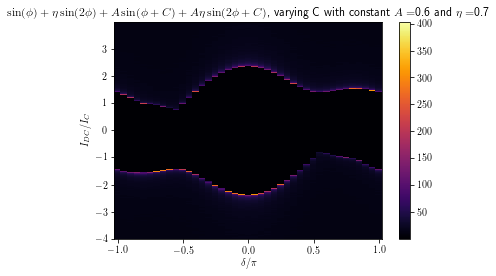

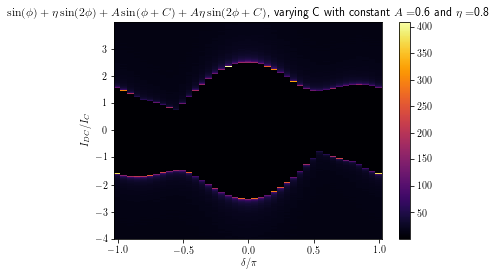

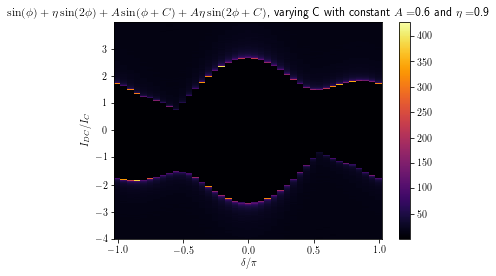

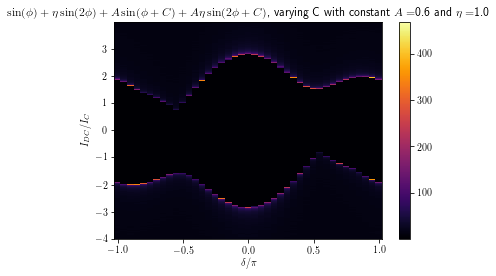

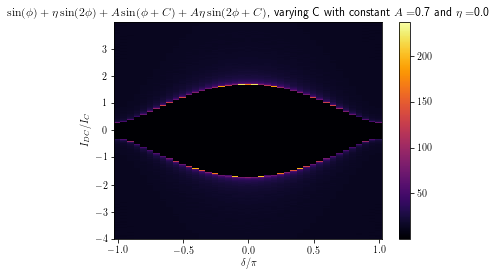

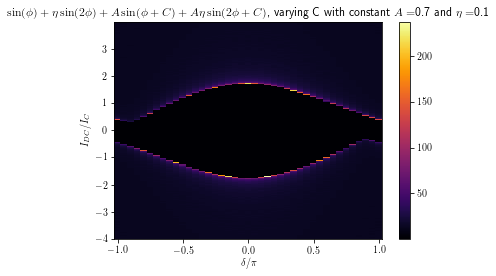

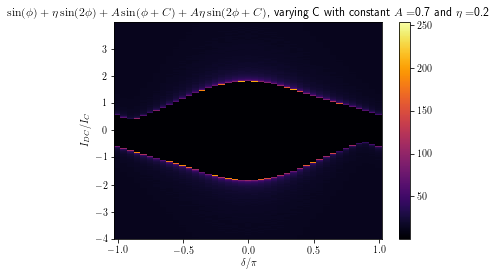

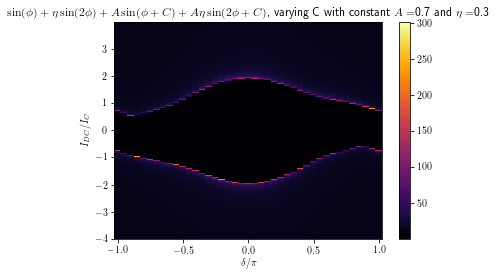

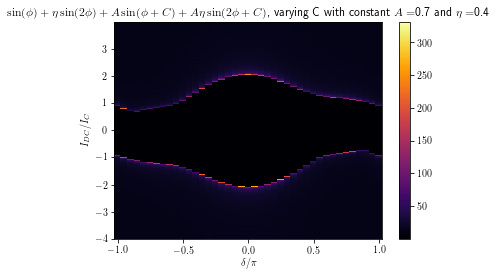

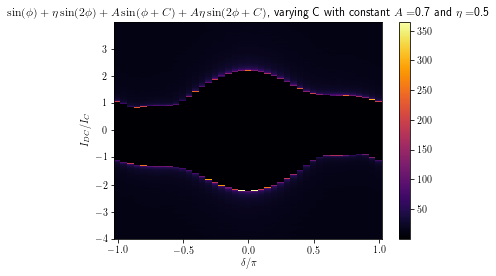

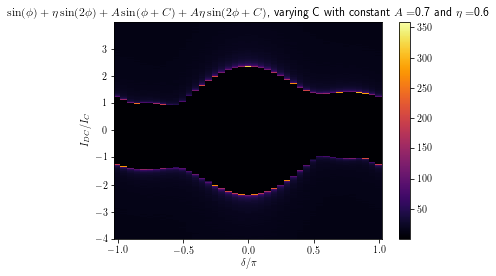

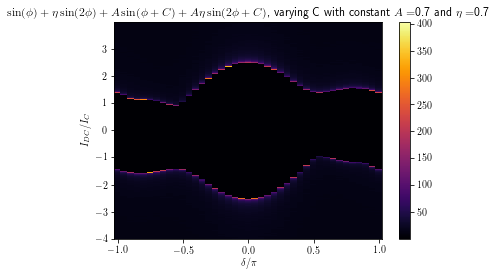

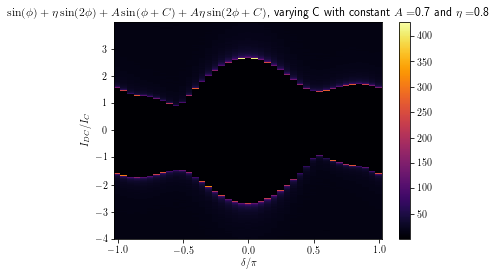

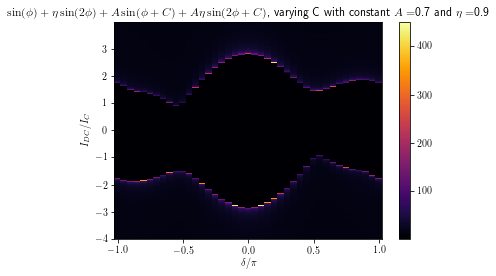

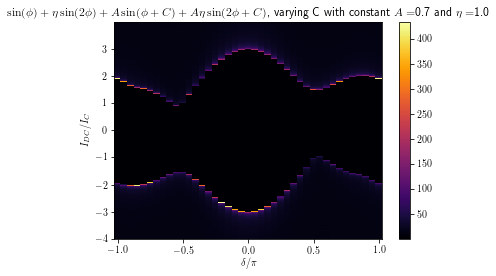

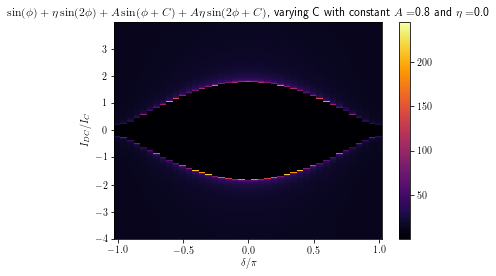

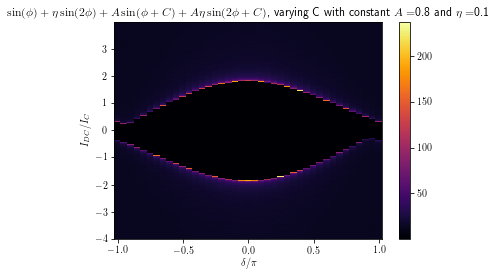

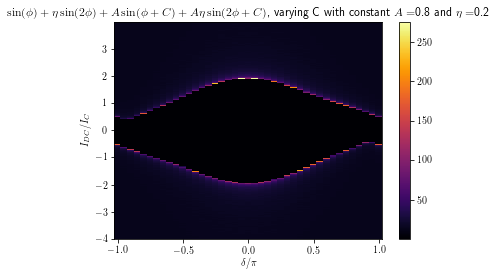

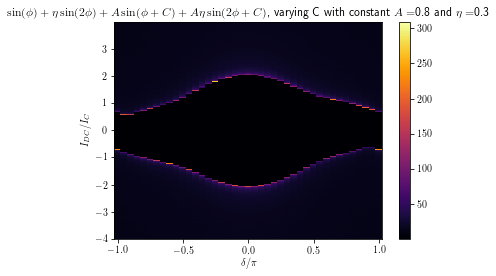

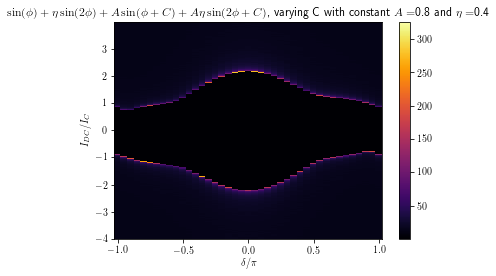

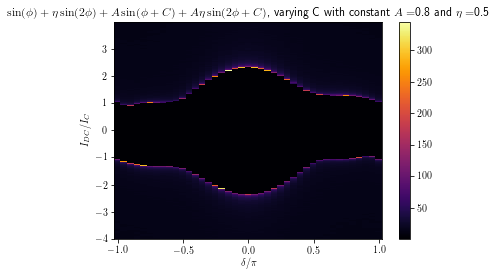

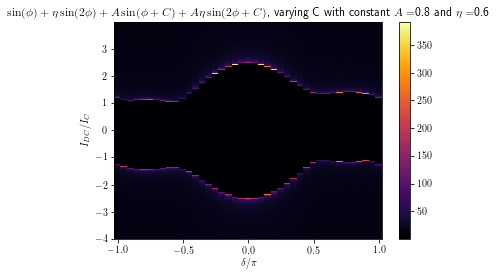

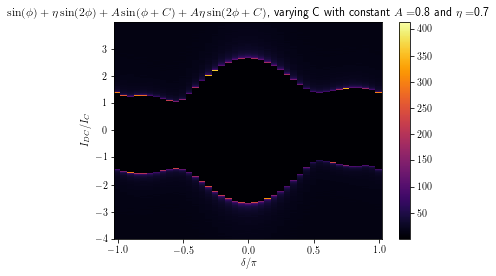

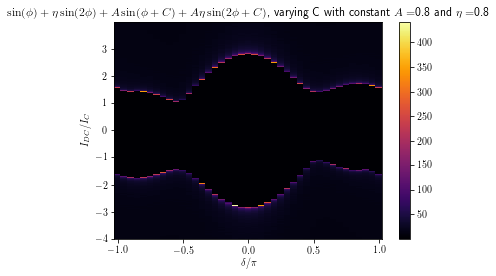

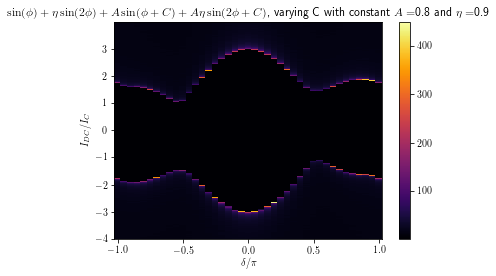

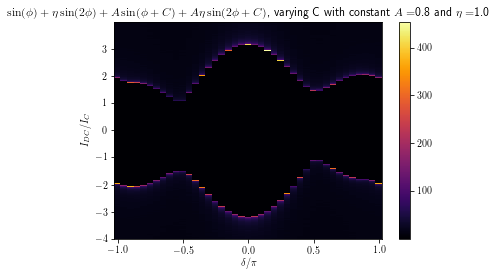

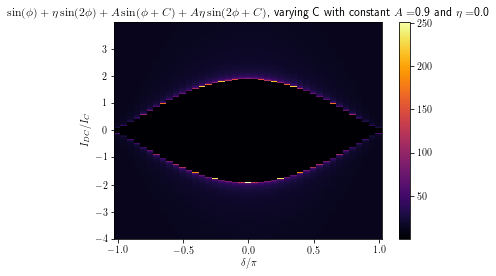

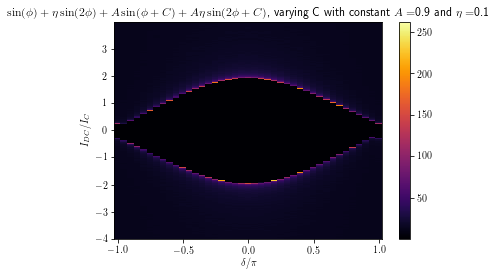

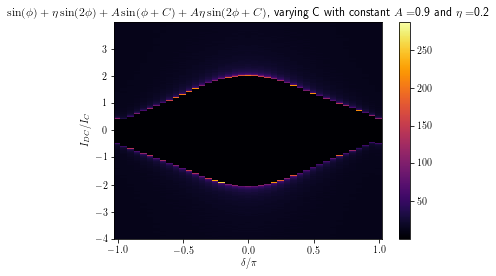

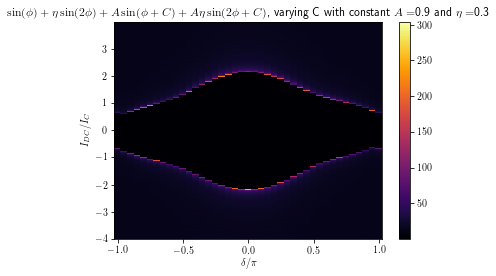

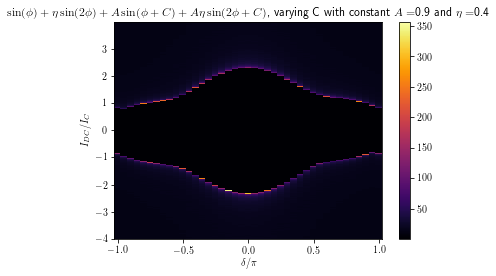

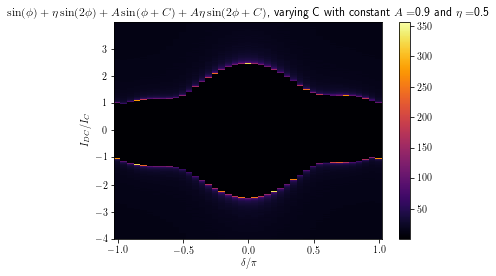

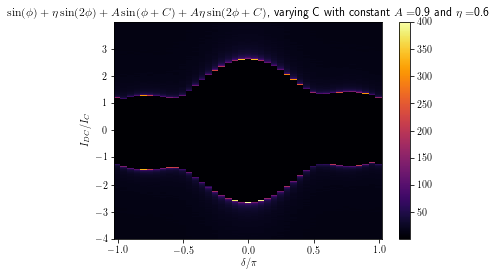

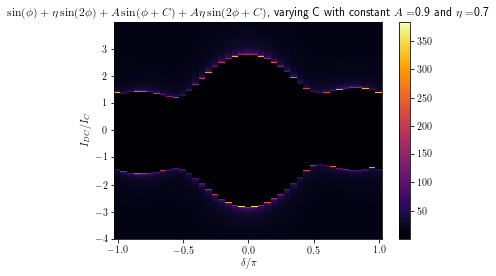

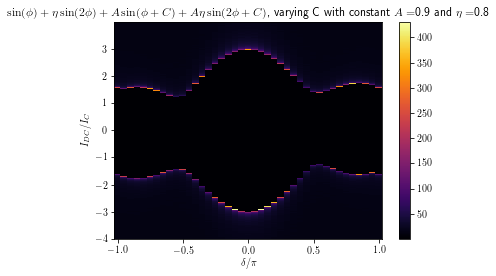

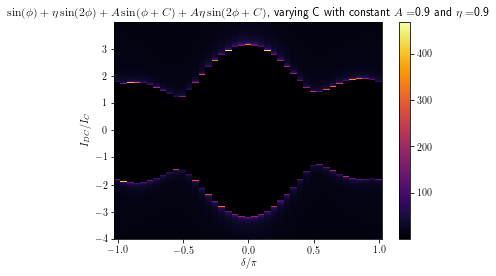

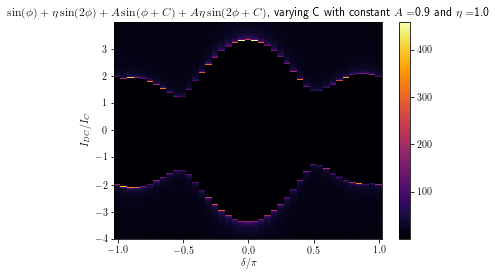

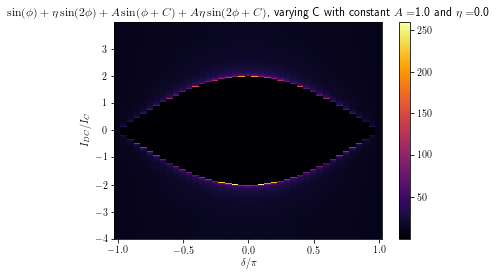

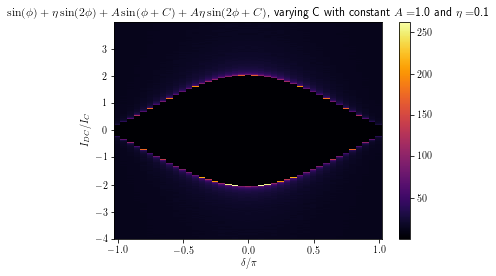

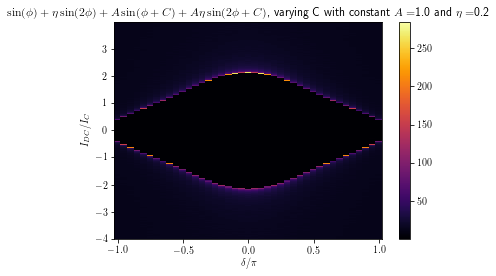

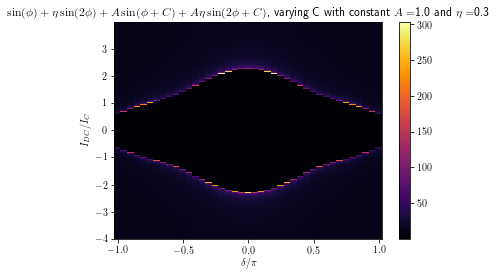

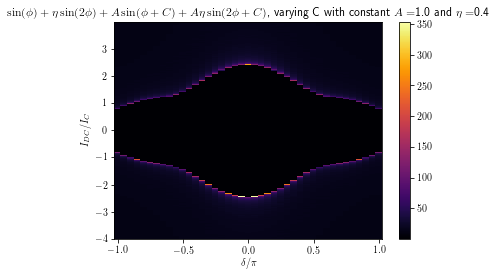

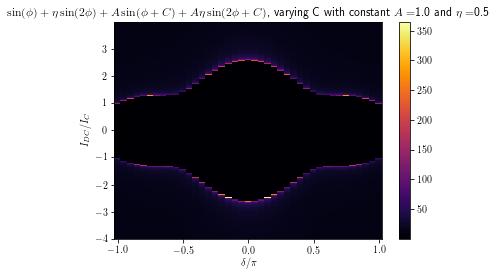

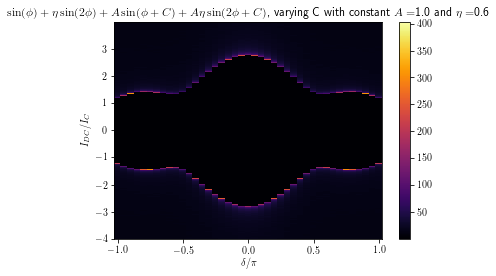

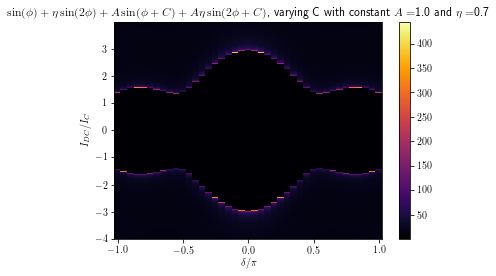

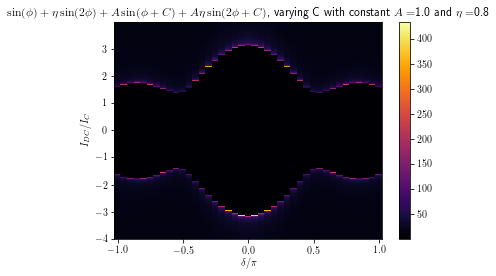

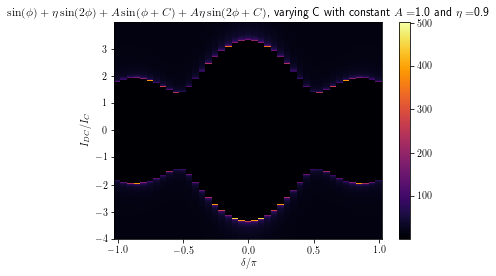

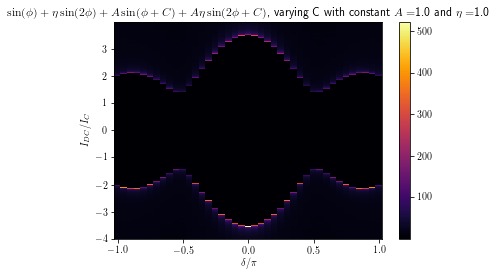

In [522]:
plt.figure()
for i in range(0,len(eta)):
    plt.pcolor(C/np.pi,IDC/Ic,np.squeeze(np.transpose(DVDI[:,:,i])),cmap='inferno',linewidth=0,rasterized=True,shading='auto')
    plt.xlabel("$\delta/\pi$")
    plt.ylabel("$I_{DC}/I_C$")
    plt.colorbar()

    plt.title("$\sin(\phi)+\eta\sin(2\phi)+A\sin(\phi+C)+A\eta\sin(2\phi+C)$, varying C with constant $A=$"+str(A[i])+" and $\eta=$"+str(eta[i]))
    plt.show()
#plt.savefig("./eta0p7_A0p5/two_channels_A0p5_eta_0p7_step_0p005_41ptC.pdf")


### Find $I_{C+}$, $I_{C-}$, asymmetry, and peak heights

In [12]:
from scipy.signal import find_peaks

In [14]:
Icn=np.empty([len(C),len(eta)])
Icp=np.empty([len(C),len(eta)])
peak_n=np.empty([len(C),len(eta)])
peak_p=np.empty([len(C),len(eta)])
asymmetry=np.empty([len(C),len(eta)])

for j in range(0,len(eta)):
    for i in range(0,len(C)):
        grad=np.abs(np.squeeze(np.gradient(DVDI[i,:,j]))) # find the sharpest step
        
        Index, Height=find_peaks(grad,distance=30,height=5)#prominence=2)#
        if len(Index)==2:
            Icn[i,j]=np.abs(IDC[Index[0]])
            Icp[i,j]=np.abs(IDC[Index[1]])
            asymmetry[i,j]=Icp[i,j]/Icn[i,j]
            peak_n[i]=DVDI[i,Index[0],j]
            peak_p[i]=DVDI[i,Index[1],j]
        elif(len(Index)>2):
            print("C= "+str(np.round(C[i]/np.pi,3))+"*pi has more than one peak: "+str(C[i])+" at "+str(Index))
        elif(len(Index)==1):
            Icn[i,j]=np.abs(IDC[Index[0]])
            Icp[i,j]=0 #np.abs(IDC[Index[1]])
            asymmetry[i,j]=1#Icp[i,j]/Icn[i,j]
            peak_n[i]=DVDI[i,Index[0],j]
            peak_p[i]=DVDI[i,800,j] #DVDI[i,Index[1],j]
            print("only one peak found")
        else:
            Icn[i,j]=0 #np.abs(IDC[Index[0]])
            Icp[i,j]=0 #np.abs(IDC[Index[1]])
            asymmetry[i,j]=1#Icp[i,j]/Icn[i,j]
            peak_n[i]=DVDI[i,800,j] #DVDI[i,Index[0],j]
            peak_p[i]=DVDI[i,800,j] #DVDI[i,Index[1],j]
            print("No peak found at C="+str(C[i]/np.pi)+"$\pi$, eta="+str(eta[j])+", A="+str(A[j]))

No peak found at C=-1.0$\pi$, eta=0.0, A=1.0
No peak found at C=1.0000000000000018$\pi$, eta=0.0, A=1.0


### Plot peak heights

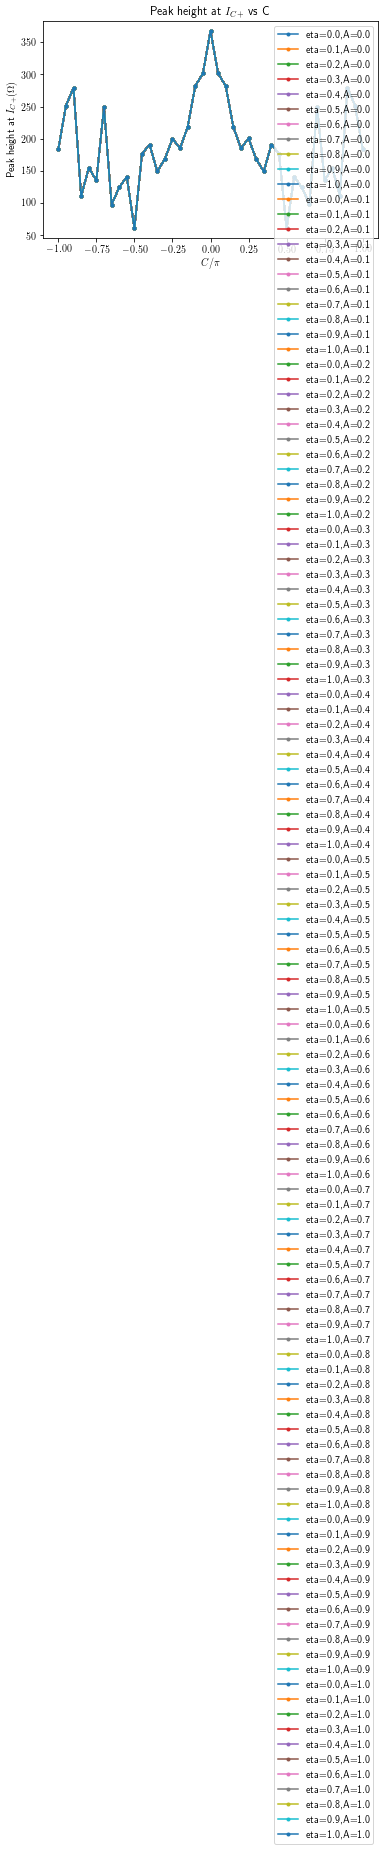

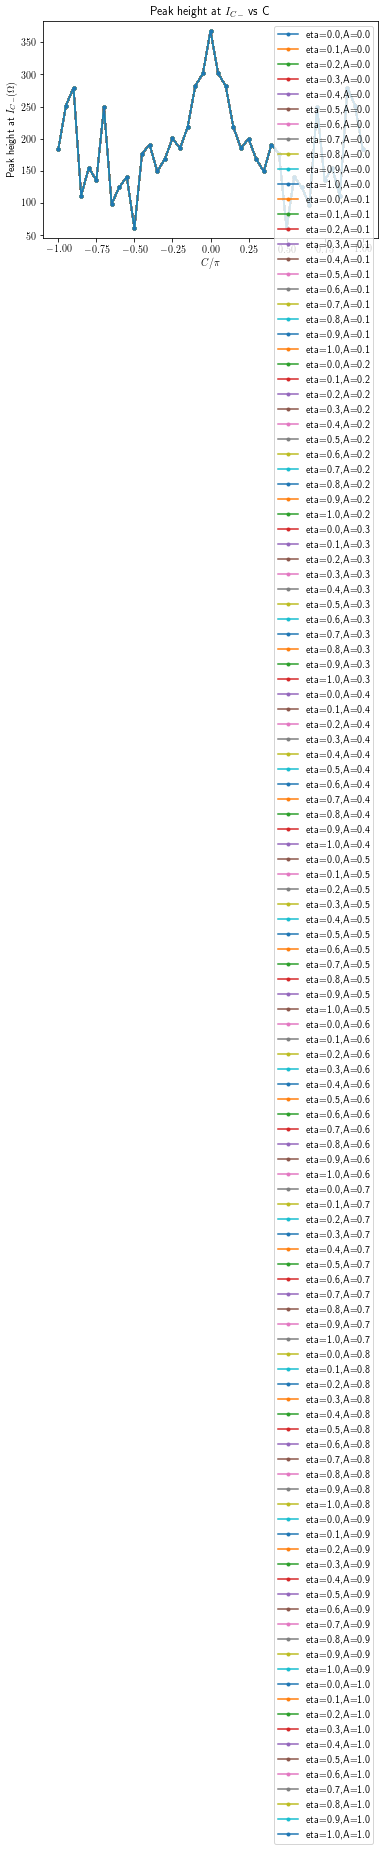

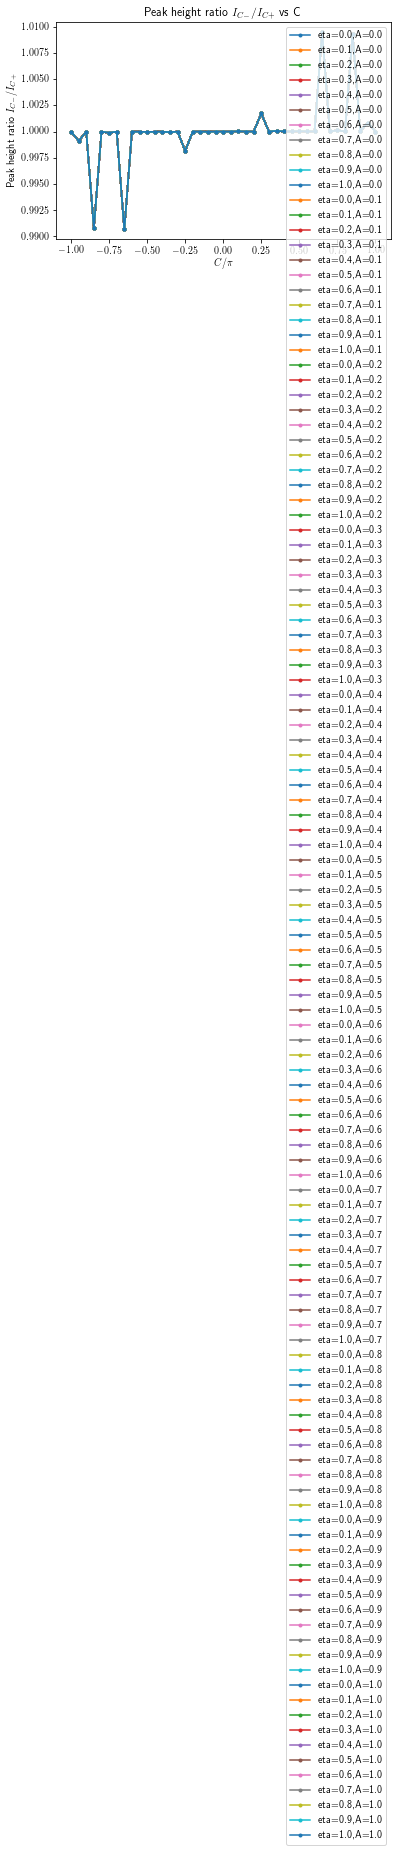

In [16]:
plt.figure()
for i in range(0,len(eta)):
    plt.plot(C/np.pi,peak_p[:,i],'.-',label='eta='+str(eta[i])+",A="+str(A[i]))
plt.title('Peak height at $I_{C+}$ vs C')
plt.xlabel('$C/\pi$')
plt.ylabel('Peak height at $I_{C+}(\Omega)$')
plt.legend(loc=0)

plt.figure()
for i in range(0,len(eta)):
    plt.plot(C/np.pi,peak_n[:,i],'.-',label='eta='+str(eta[i])+",A="+str(A[i]))
plt.title('Peak height at $I_{C-}$ vs C')
plt.xlabel('$C/\pi$')
plt.ylabel('Peak height at $I_{C-}(\Omega)$')
plt.legend(loc=0)

plt.figure()
for i in range(0,len(eta)):
    plt.plot(C/np.pi,peak_p[:,i]/peak_n[:,i],'.-',label='eta='+str(eta[i])+",A="+str(A[i]))
plt.title('Peak height ratio $I_{C-}/I_{C+}$ vs C')
plt.xlabel('$C/\pi$')
plt.ylabel('Peak height ratio $I_{C-}/I_{C+}$')
plt.legend(loc=0)
#plt.plot(C/np.pi,peak_n/peak_p,'.-',label='Peak height ratio $I_{C-}/I_{C+}$')
#plt.xlabel('$C/\pi$')
#plt.ylabel('Peak height ratio $I_{C-}/I_{C+}$')


### Asymmetry

In [17]:
np.dstack([eta,A])

array([[[0. , 0. ],
        [0.1, 0. ],
        [0.2, 0. ],
        [0.3, 0. ],
        [0.4, 0. ],
        [0.5, 0. ],
        [0.6, 0. ],
        [0.7, 0. ],
        [0.8, 0. ],
        [0.9, 0. ],
        [1. , 0. ],
        [0. , 0.1],
        [0.1, 0.1],
        [0.2, 0.1],
        [0.3, 0.1],
        [0.4, 0.1],
        [0.5, 0.1],
        [0.6, 0.1],
        [0.7, 0.1],
        [0.8, 0.1],
        [0.9, 0.1],
        [1. , 0.1],
        [0. , 0.2],
        [0.1, 0.2],
        [0.2, 0.2],
        [0.3, 0.2],
        [0.4, 0.2],
        [0.5, 0.2],
        [0.6, 0.2],
        [0.7, 0.2],
        [0.8, 0.2],
        [0.9, 0.2],
        [1. , 0.2],
        [0. , 0.3],
        [0.1, 0.3],
        [0.2, 0.3],
        [0.3, 0.3],
        [0.4, 0.3],
        [0.5, 0.3],
        [0.6, 0.3],
        [0.7, 0.3],
        [0.8, 0.3],
        [0.9, 0.3],
        [1. , 0.3],
        [0. , 0.4],
        [0.1, 0.4],
        [0.2, 0.4],
        [0.3, 0.4],
        [0.4, 0.4],
        [0.5, 0.4],


### Asymmetry vs C, grouped by the same A

<Figure size 432x288 with 0 Axes>

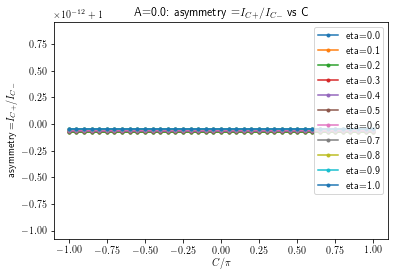

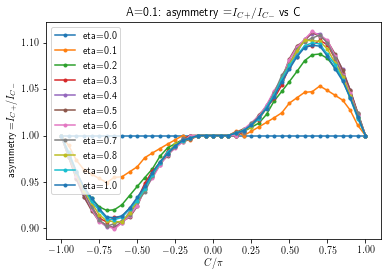

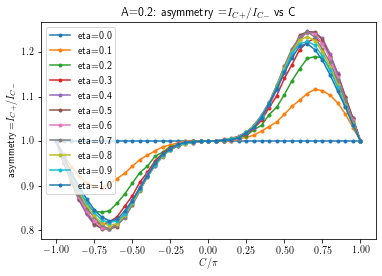

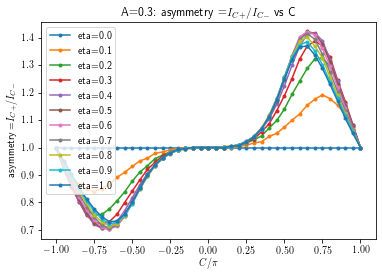

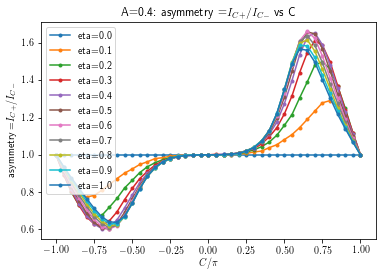

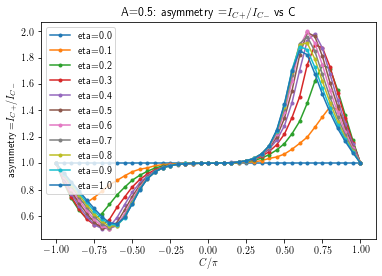

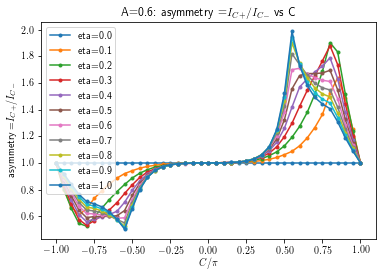

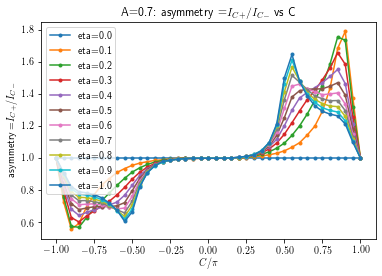

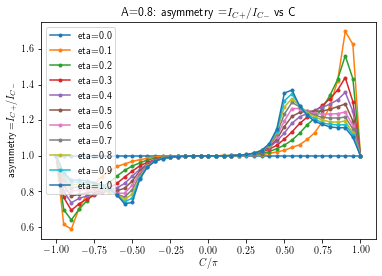

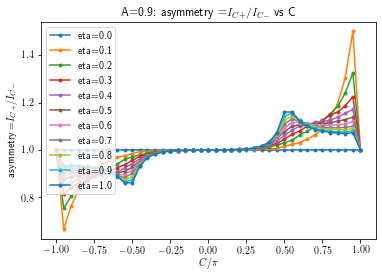

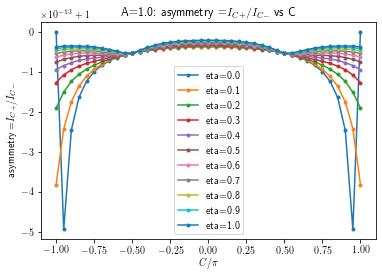

In [19]:
plt.figure()
for j in range(0,11):
    plt.figure()
    for i in range(0+j*11,(j+1)*11): 
        plt.plot(C/np.pi,asymmetry[:,i],'.-',label='eta='+str(eta[i]))

    plt.legend(loc=0)
    plt.title('A='+str(A[0+j*11])+': asymmetry =$I_{C+}/I_{C-}$ vs C')
    plt.xlabel('$C/\pi$')
    plt.ylabel('asymmetry =$I_{C+}/I_{C-}$')
    plt.show()

### Asymmetry vs C, grouped by the same eta

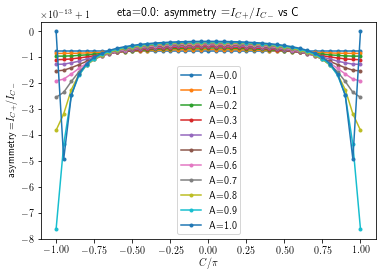

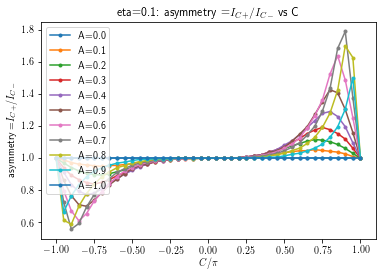

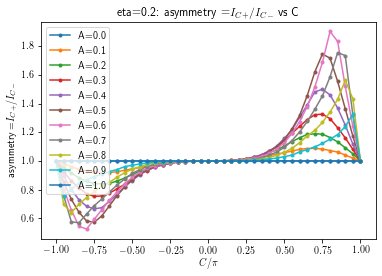

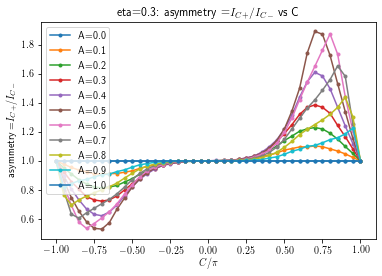

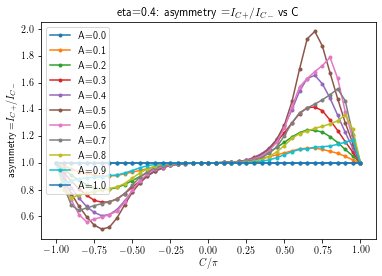

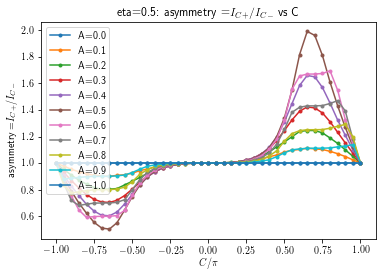

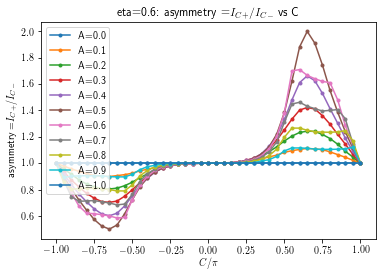

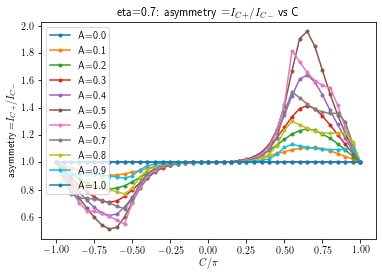

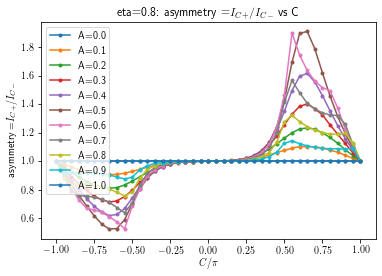

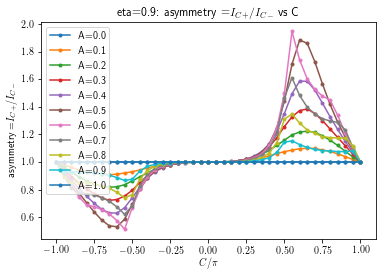

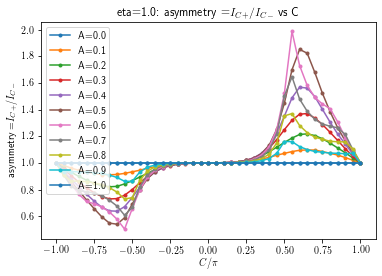

In [20]:
for j in range(0,11):
    plt.figure()
    for i in range(j,len(eta),11):
        plt.plot(C/np.pi,asymmetry[:,i],'.-',label='A='+str(A[i]))

    plt.legend(loc=0)
    plt.title('eta='+str(eta[j])+': asymmetry =$I_{C+}/I_{C-}$ vs C')
    plt.xlabel('$C/\pi$')
    plt.ylabel('asymmetry =$I_{C+}/I_{C-}$')
    plt.show()

### $I_{C+}$ vs C, grouped by the same A

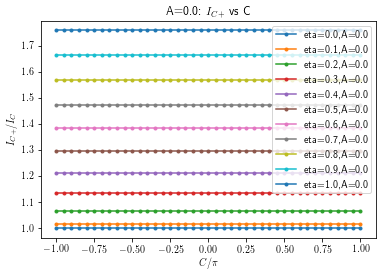

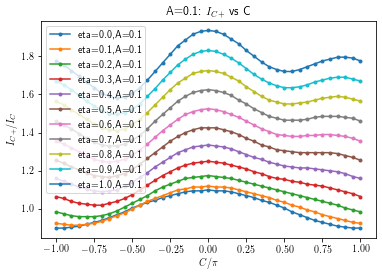

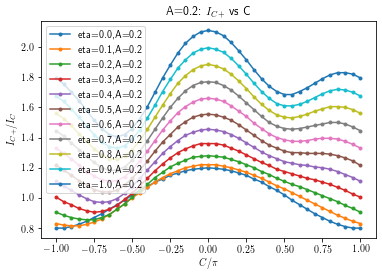

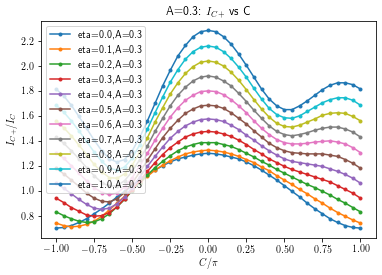

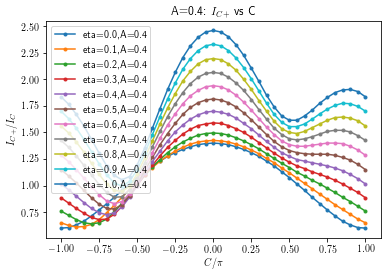

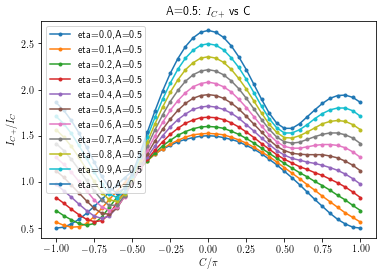

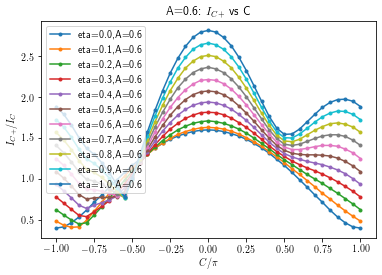

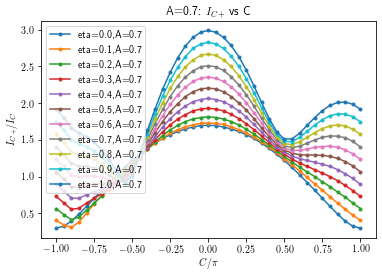

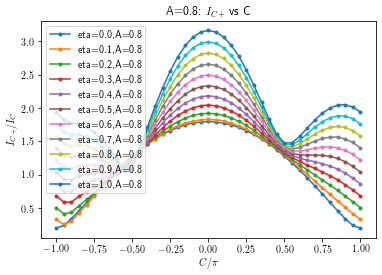

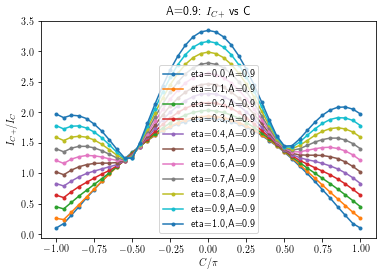

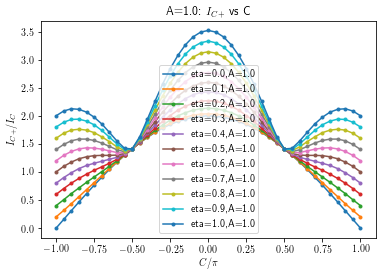

In [22]:
for j in range(0,11):
    plt.figure()
    for i in range(0+j*11,(j+1)*11): 
        plt.plot(C/np.pi,Icp[:,i]/Ic,'.-',label='eta='+str(eta[i])+",A="+str(A[i]))
    plt.title('A='+str(A[0+j*11])+': $I_{C+}$ vs C')
    plt.xlabel('$C/\pi$')
    plt.ylabel('$I_{C+}/I_C$')
    plt.legend(loc=0)
    plt.show()

### $I_{C-}$ vs C

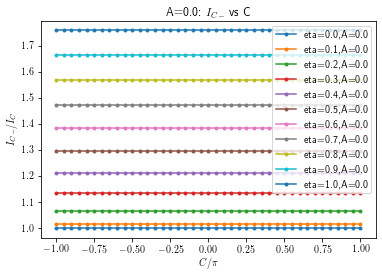

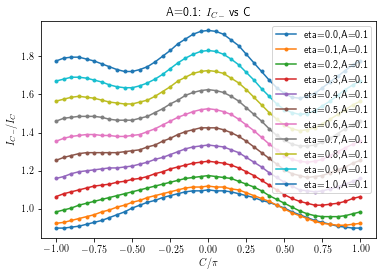

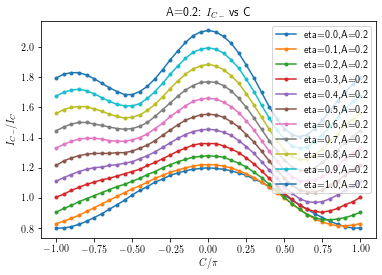

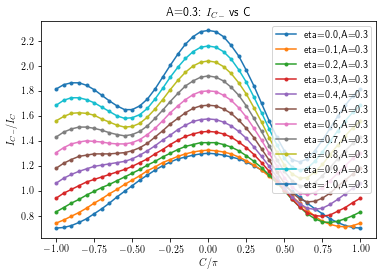

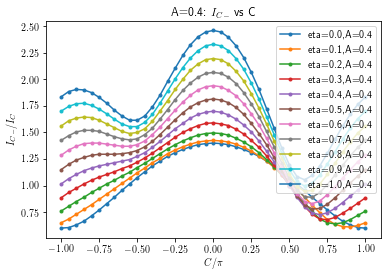

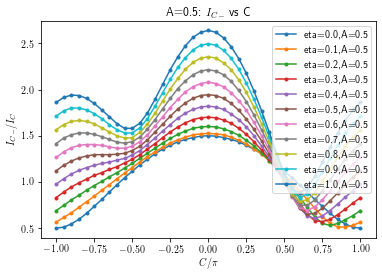

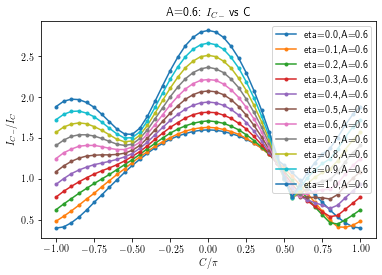

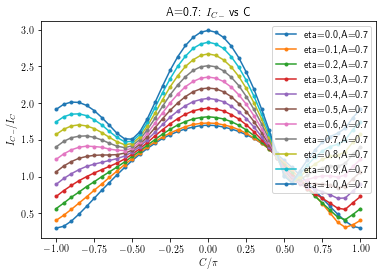

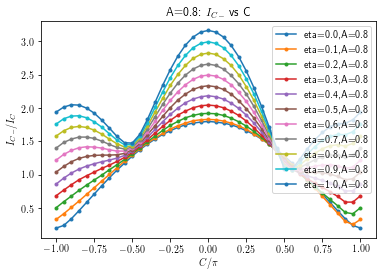

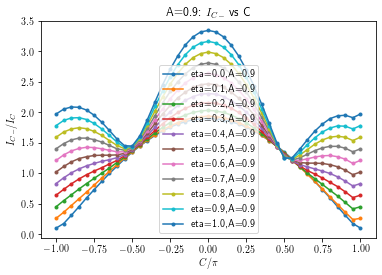

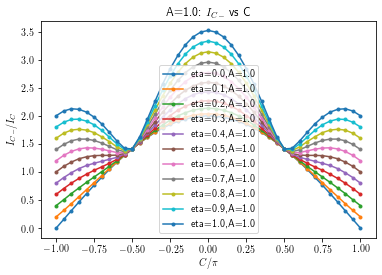

In [24]:
for j in range(0,11):
    plt.figure()
    for i in range(0+j*11,(j+1)*11): 
        plt.plot(C/np.pi,Icn[:,i]/Ic,'.-',label='eta='+str(eta[i])+",A="+str(A[i]))
    plt.title('A='+str(A[0+j*11])+': $I_{C-}$ vs C')
    plt.xlabel('$C/\pi$')
    plt.ylabel('$I_{C-}/I_C$')
    plt.legend(loc=0)
    plt.show()

## Individual mat file

In [58]:

    

#for i in range(0, len(mats)):
#    IDC_ mats[i]['eta'] mats[i]['A']

#data=loadmat("./several_eta_A/two_channels_A0.0_eta_0.0_step_0p005_41ptC.mat")

#IDC=np.squeeze(data['IDC'])
#C=np.squeeze(data['C'])
#V=data['V']
#DVDI=data['DVDI']
#Ic=2e-6
#Rn=13


#plt.figure()
#ax=plt.pcolor(C/np.pi,IDC/Ic,np.transpose(DVDI),cmap='inferno',linewidth=0,rasterized=True,shading='auto')
#plt.xlabel("$\delta/\pi$")
#plt.ylabel("$I_{DC}/I_C$")
#plt.colorbar()

#plt.title("$\sin(\phi)+\eta\sin(2\phi)+A\sin(\phi+C)+A\eta\sin(2\phi+C)$, varying C with constant $A=$"+str(A)+" and $\eta=$"+str(eta))
#plt.savefig("./eta0p7_A0p5/two_channels_A0p5_eta_0p7_step_0p005_41ptC.pdf")


TypeError: _vhstack_dispatcher() takes 1 positional argument but 4 were given

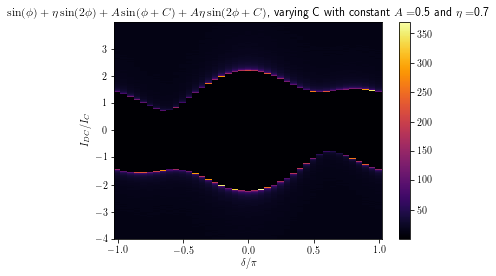

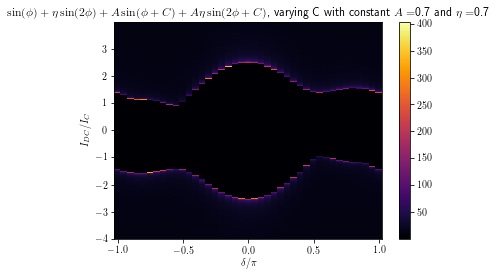

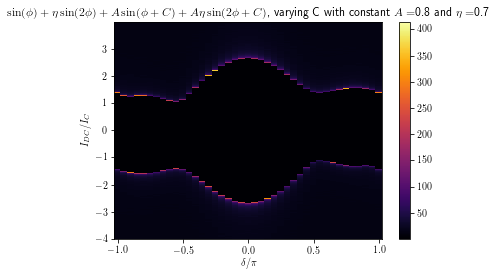

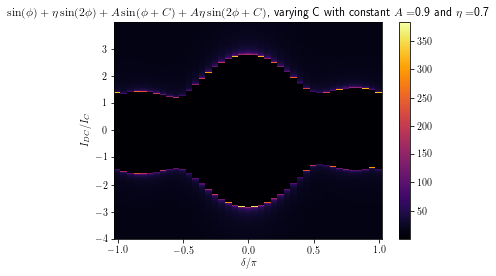

In [9]:
data_eta0p7_A0p5=loadmat("./eta0p7_A0p5/simulation_dVdI_vs_C_constant_A_0p5_eta_0p7_two_channels_step_0p005.mat")
data_eta0p7_A0p7=loadmat("./eta0p7_A0p7/simulation_dVdI_vs_C_constant_A_0p7_eta_0p7_two_channels_step_0p005.mat")
data_eta0p7_A0p8=loadmat("./eta0p7_A0p8/simulation_dVdI_vs_C_constant_A_0p8_eta_0p7_two_channels_step_0p005.mat")
data_eta0p7_A0p9=loadmat("./eta0p7_A0p9/simulation_dVdI_vs_C_constant_A_0p9_eta_0p7_two_channels_step_0p005.mat")

IDC=np.squeeze(data_eta0p7_A0p5['IDC'])
C=np.squeeze(data_eta0p7_A0p5['C'])
V05=data_eta0p7_A0p5['V']
V07=data_eta0p7_A0p7['V']
V08=data_eta0p7_A0p8['V']
V09=data_eta0p7_A0p9['V']

DVDI05=data_eta0p7_A0p5['DVDI']
DVDI07=data_eta0p7_A0p7['DVDI']
DVDI08=data_eta0p7_A0p8['DVDI']
DVDI09=data_eta0p7_A0p9['DVDI']

Ic=2e-6
Rn=13
eta=0.7


A=0.5
plt.figure()
ax=plt.pcolormesh(C/np.pi,IDC/Ic,np.transpose(DVDI05),cmap='inferno',linewidth=0,rasterized=True,shading='auto')
plt.xlabel("$\delta/\pi$")
plt.ylabel("$I_{DC}/I_C$")
plt.colorbar()

plt.title("$\sin(\phi)+\eta\sin(2\phi)+A\sin(\phi+C)+A\eta\sin(2\phi+C)$, varying C with constant $A=$"+str(A)+" and $\eta=$"+str(eta))
#plt.savefig("./eta0p7_A0p5/two_channels_A0p5_eta_0p7_step_0p005_41ptC.pdf")
plt.show()

A=0.7

plt.figure()
ax=plt.pcolormesh(C/np.pi,IDC/Ic,np.transpose(DVDI07),cmap='inferno',linewidth=0,rasterized=True,shading='auto')
plt.xlabel("$\delta/\pi$")
plt.ylabel("$I_{DC}/I_C$")
plt.colorbar()

plt.title("$\sin(\phi)+\eta\sin(2\phi)+A\sin(\phi+C)+A\eta\sin(2\phi+C)$, varying C with constant $A=$"+str(A)+" and $\eta=$"+str(eta))
#plt.savefig("./eta0p7_A0p5/two_channels_A0p5_eta_0p7_step_0p005_41ptC.pdf")
plt.show()

A=0.8

plt.figure()
ax=plt.pcolormesh(C/np.pi,IDC/Ic,np.transpose(DVDI08),cmap='inferno',linewidth=0,rasterized=True,shading='auto')
plt.xlabel("$\delta/\pi$")
plt.ylabel("$I_{DC}/I_C$")
plt.colorbar()

plt.title("$\sin(\phi)+\eta\sin(2\phi)+A\sin(\phi+C)+A\eta\sin(2\phi+C)$, varying C with constant $A=$"+str(A)+" and $\eta=$"+str(eta))
#plt.savefig("./eta0p7_A0p5/two_channels_A0p5_eta_0p7_step_0p005_41ptC.pdf")
plt.show()

A=0.9

plt.figure()
ax=plt.pcolormesh(C/np.pi,IDC/Ic,np.transpose(DVDI09),cmap='inferno',linewidth=0,rasterized=True,shading='auto')
plt.xlabel("$\delta/\pi$")
plt.ylabel("$I_{DC}/I_C$")
plt.colorbar()

plt.title("$\sin(\phi)+\eta\sin(2\phi)+A\sin(\phi+C)+A\eta\sin(2\phi+C)$, varying C with constant $A=$"+str(A)+" and $\eta=$"+str(eta))
#plt.savefig("./eta0p7_A0p5/two_channels_A0p5_eta_0p7_step_0p005_41ptC.pdf")
plt.show()

# Save it into a .csv file

In [74]:
np.savetxt("./eta0p7_A0p5/csv/IDC.csv", IDC, delimiter=",")
np.savetxt("./eta0p7_A0p5/csv/C.csv", C, delimiter=",")
np.savetxt("./eta0p7_A0p5/csv/V.csv", V, delimiter=",")
np.savetxt("./eta0p7_A0p5/csv/DVDI.csv", DVDI, delimiter=",")


In [75]:
print(C.shape)
print(IDC_array.shape)

(41,)
(1600,)


In [10]:
from scipy.signal import find_peaks


In [13]:
#A=0.5
Icn05=np.empty(len(C))
Icp05=np.empty(len(C))
peak_n05=np.empty(len(C))
peak_p05=np.empty(len(C))
asymmetry05=np.empty(len(C))
for i in range(0,len(C)):
    Index, Height=find_peaks(DVDI05[i,:],distance=200,height=50)
    
    Icn05[i]=np.abs(IDC[Index[0]])
    Icp05[i]=np.abs(IDC[Index[1]])
    asymmetry05[i]=Icp05[i]/Icn05[i]
    peak_n05[i]=Height['peak_heights'][0]
    peak_p05[i]=Height['peak_heights'][1]
    if(len(Index)>2):
        print("C= "+str(np.round(C[i]/np.pi,3))+"*pi has more than one peak: "+str(C[i])+" at "+str(Index))

In [14]:
#A=0.7
Icn07=np.empty(len(C))
Icp07=np.empty(len(C))
peak_n07=np.empty(len(C))
peak_p07=np.empty(len(C))
asymmetry07=np.empty(len(C))
for i in range(0,len(C)):
    Index, Height=find_peaks(DVDI07[i,:],distance=200,height=50)
    
    Icn07[i]=np.abs(IDC[Index[0]])
    Icp07[i]=np.abs(IDC[Index[1]])
    asymmetry07[i]=Icp07[i]/Icn07[i]
    peak_n07[i]=Height['peak_heights'][0]
    peak_p07[i]=Height['peak_heights'][1]
    if(len(Index)>2):
        print("C= "+str(np.round(C[i]/np.pi,3))+"*pi has more than one peak: "+str(C[i])+" at "+str(Index))

In [15]:
#A=0.8
Icn08=np.empty(len(C))
Icp08=np.empty(len(C))
peak_n08=np.empty(len(C))
peak_p08=np.empty(len(C))
asymmetry08=np.empty(len(C))
for i in range(0,len(C)):
    Index, Height=find_peaks(DVDI08[i,:],distance=200,height=50)
    
    Icn08[i]=np.abs(IDC[Index[0]])
    Icp08[i]=np.abs(IDC[Index[1]])
    asymmetry08[i]=Icp08[i]/Icn08[i]
    peak_n08[i]=Height['peak_heights'][0]
    peak_p08[i]=Height['peak_heights'][1]
    if(len(Index)>2):
        print("C= "+str(np.round(C[i]/np.pi,3))+"*pi has more than one peak: "+str(C[i])+" at "+str(Index))

In [16]:
#A=0.9
Icn09=np.empty(len(C))
Icp09=np.empty(len(C))
peak_n09=np.empty(len(C))
peak_p09=np.empty(len(C))
asymmetry09=np.empty(len(C))
for i in range(0,len(C)):
    Index, Height=find_peaks(DVDI09[i,:],distance=200,height=50)
    
    Icn09[i]=np.abs(IDC[Index[0]])
    Icp09[i]=np.abs(IDC[Index[1]])
    asymmetry09[i]=Icp09[i]/Icn09[i]
    peak_n09[i]=Height['peak_heights'][0]
    peak_p09[i]=Height['peak_heights'][1]
    if(len(Index)>2):
        print("C= "+str(np.round(C[i]/np.pi,3))+"*pi has more than one peak: "+str(C[i])+" at "+str(Index))

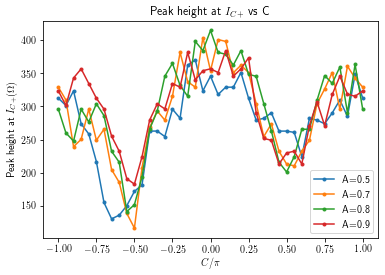

In [38]:
plt.figure()
plt.plot(C/np.pi,peak_p05,'.-',label='A=0.5')
plt.plot(C/np.pi,peak_p07,'.-',label='A=0.7')
plt.plot(C/np.pi,peak_p08,'.-',label='A=0.8')
plt.plot(C/np.pi,peak_p09,'.-',label='A=0.9')


#plt.plot(C/np.pi,np.flip(peak_n),'.',label='Peak height at $I_{C-}$, flipped, same as blue')
#plt.plot(C/np.pi,peak_n05,'.-',label='Peak height at $I_{C-}$')
plt.title('Peak height at $I_{C+}$ vs C')
plt.xlabel('$C/\pi$')
plt.ylabel('Peak height at $I_{C+}(\Omega)$')
plt.legend(loc=0)

#plt.figure()
#plt.plot(C/np.pi,peak_n/peak_p,'.-',label='Peak height ratio $I_{C-}/I_{C+}$')
#plt.xlabel('$C/\pi$')
#plt.ylabel('Peak height ratio $I_{C-}/I_{C+}$')


Text(0, 0.5, 'asymmetry =$I_{C+}/I_{C-}$')

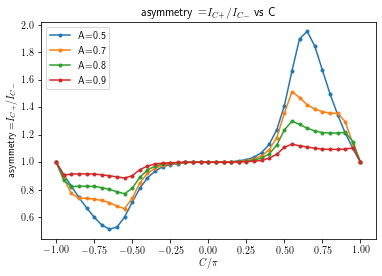

In [36]:
plt.figure()
plt.plot(C/np.pi,asymmetry05,'.-', label='A=0.5')
plt.plot(C/np.pi,asymmetry07,'.-', label='A=0.7')
plt.plot(C/np.pi,asymmetry08,'.-', label='A=0.8')
plt.plot(C/np.pi,asymmetry09,'.-', label='A=0.9')

plt.legend(loc=0)
plt.title('asymmetry =$I_{C+}/I_{C-}$ vs C')
plt.xlabel('$C/\pi$')
plt.ylabel('asymmetry =$I_{C+}/I_{C-}$')

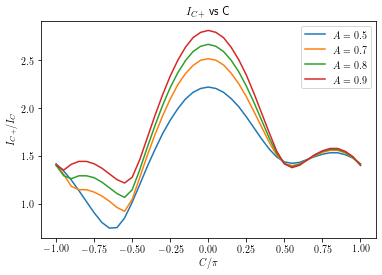

In [35]:
plt.figure()
plt.plot(C/np.pi,Icp05/Ic,label='$A=0.5$')
plt.plot(C/np.pi,Icp07/Ic,label='$A=0.7$')
plt.plot(C/np.pi,Icp08/Ic,label='$A=0.8$')
plt.plot(C/np.pi,Icp09/Ic,label='$A=0.9$')

#plt.plot(C/np.pi,Icn/Ic,label='$I_{C-}$')
plt.title('$I_{C+}$ vs C')
plt.xlabel('$C/\pi$')
plt.ylabel('$I_{C+}/I_C$')
plt.legend(loc=0)

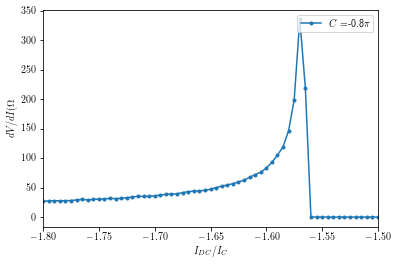

In [46]:
plt.figure()
plt.plot(IDC_array/Ic,DVDI[4,:],'.-',label='$C=$'+str(np.round(C[4]/np.pi,3))+"$\pi$")
plt.xlim([-1.8,-1.5])
plt.xlabel('$I_{DC}/I_C$')
plt.ylabel('$dV/dI(\Omega$')
plt.legend(loc=1)

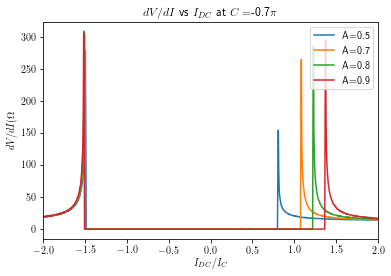

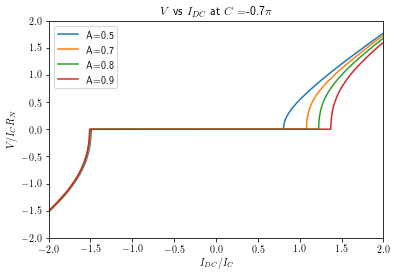

In [42]:
C_index=6
plt.figure()
plt.plot(IDC/Ic,DVDI05[C_index,:],'-',label='A=0.5')
plt.plot(IDC/Ic,DVDI07[C_index,:],'-',label='A=0.7')
plt.plot(IDC/Ic,DVDI08[C_index,:],'-',label='A=0.8')
plt.plot(IDC/Ic,DVDI09[C_index,:],'-',label='A=0.9')

plt.xlim([-2,2])
plt.title('$dV/dI$ vs $I_{DC}$ at $C=$'+str(np.round(C[C_index]/np.pi,4))+"$\pi$")
plt.xlabel('$I_{DC}/I_C$')
plt.ylabel('$dV/dI(\Omega$')
plt.legend(loc=1)


plt.figure()
plt.plot(IDC/Ic,V05[C_index,:]/Ic/Rn,'-',label='A=0.5')
plt.plot(IDC/Ic,V07[C_index,:]/Ic/Rn,'-',label='A=0.7')
plt.plot(IDC/Ic,V08[C_index,:]/Ic/Rn,'-',label='A=0.8')
plt.plot(IDC/Ic,V09[C_index,:]/Ic/Rn,'-',label='A=0.9')

plt.xlim([-2,2])
plt.ylim([-2,2])
plt.title('$V$ vs $I_{DC}$ at $C=$'+str(np.round(C[C_index]/np.pi,4))+"$\pi$")
plt.xlabel('$I_{DC}/I_C$')
plt.ylabel('$V/I_CR_N$')
plt.legend(loc=0)

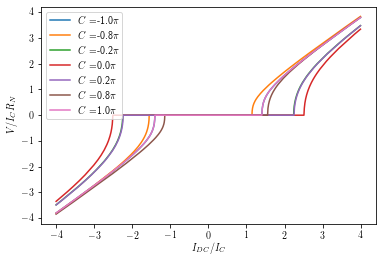

In [63]:
plt.figure()
#alist=[0,2,8,10,12,18,20]
alist=[0,4,16,20,24,36,40]

for i in alist :
    plt.plot(IDC_array/Ic,V[i,:]/Ic/Rn,'-',label='$C=$'+str(np.round(C[i]/np.pi,3))+"$\pi$")
#plt.xlim([-4,3])
#plt.ylim([-0.00005,0.000025])
plt.xlabel('$I_{DC}/I_C$')
plt.ylabel('$V/I_CR_N$')
plt.legend(loc=0)